In [1]:
%pip install gpflow
%pip install plotnine

     |████████████████████████████████| 286 kB 4.3 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
from scipy.io import loadmat
import random
import math
import tensorflow_probability as tfp

_paper_name_ establishes the reusable name of the paper, it represents the directory under data_papers on the google drive

In [4]:
paper_name = "gpCIFAR10"

In [5]:
# Make sure you mounted your google drive!!
import os, sys
import errno

# make a directory if it does not exist
def make_dir_if_not_exist(used_path):
    if not os.path.isdir(used_path):
        try:
            os.mkdir(used_path)
        except OSError as exc:
            if exc.errno != errno.EEXIST:
                raise exc
            else:
                raise ValueError(f'{used_path} directoy cannot be created because its parent directory does not exist.')

# make directories if they do not exist

make_dir_if_not_exist("/content/drive/MyDrive/data_papers/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_history/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/gp_collab/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_predictions/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/")


This will use the [CIFAR10 dataset](https://www.cs.toronto.edu/%7Ekriz/cifar.html). The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 

* A. Krizhevsky "Learning multiple layers of features from tiny images" 2009.

[Here](https://en.wikipedia.org/wiki/CIFAR-10) is the wiki page.



In [6]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)


170508288/170498071 [==============================] - 11s 0us/step


In [7]:
# Set up the imports

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Concatenate, Add, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import numpy as np

import site
import os
import tensorflow as tf
import pandas as pd
import h5py as h5
import matplotlib.pyplot as plt
import errno
import numpy as np
import itertools
import multiprocessing
import json
import datetime
import random
from collections import defaultdict
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import  Dense, Flatten, Activation, Dropout, Embedding, Conv1D, Conv2D, MaxPooling2D, MaxPooling1D, Concatenate, BatchNormalization, GaussianNoise, AveragePooling2D
from tensorflow.keras.layers import LSTM, TimeDistributed, Permute, Reshape, Lambda, RepeatVector, Input, Multiply, SimpleRNN, GRU, LeakyReLU, Add
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import to_categorical
from tensorflow.summary import create_file_writer
from tensorflow.keras.regularizers import L2

pd.set_option('display.width', 400)
pd.set_option('display.max_columns', 40)


## Inspect and Preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* turn test into validation and slice some extra for test
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel.
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.
# Why greyscale?
* So we get worse performance and have less discriminating features, allowing us to discern the impact of the GP on the features in _collaborative_ learning better.


In [8]:
x_train.shape

(50000, 32, 32, 3)

In [9]:
# (x_train, y_train), (x_test, y_test)
train_data = x_train[:40000]
validation_data = x_train[40000:]
test_data = x_test
train_targets = y_train[:40000]
validation_targets = y_train[40000:]
test_targets = y_test

In [10]:
def plot_images(images, nrows, ncols, cls_true, cls_pred=None):
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 2*nrows))
    for i, ax in enumerate(axes.flat): 
        # Pretty string with actual label
        true_number = ''.join(str(x) for x in cls_true[i] if x != 10)
        title = "Label: {0}".format(true_number)
            
        ax.imshow(images[i,:,:,:])
        ax.set_title(title)   
        ax.set_xticks([]); ax.set_yticks([])

def plot_sample(num_sample=10):
    idxs = sorted(random.sample(range(train_targets.shape[0]),num_sample))
    plot_images(train_data[idxs,:,:,:],2,math.ceil(num_sample/2),train_targets[idxs])    
    print(idxs)


[1403, 4868, 12201, 13653, 16894, 17897, 20623, 22532, 30925, 37578]


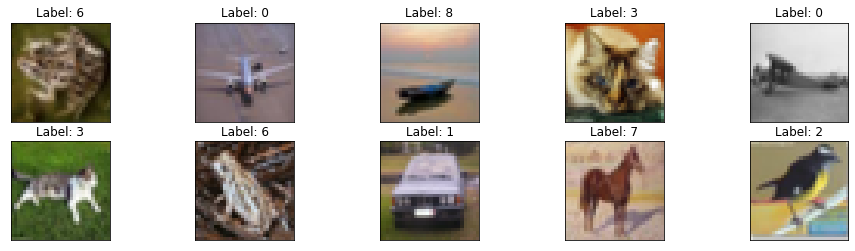

In [11]:
plot_sample(10)

Convert the train, test and validation data to greyscale

In [12]:
train_data_grey = train_data.mean(axis=3)
train_data_grey = np.expand_dims(train_data_grey,axis=3)
# train_data_grey = np.moveaxis(train_data_grey, 0, 3)

test_data_grey = test_data.mean(axis=3)
test_data_grey = np.expand_dims(test_data_grey,axis=3)
# test_data_grey = np.moveaxis(test_data_grey, 0, 3)

validation_data_grey = validation_data.mean(axis=3)
validation_data_grey = np.expand_dims(validation_data_grey,axis=3)
# validation_data_grey = np.moveaxis(validation_data_grey, 0, 3)

print(train_data.shape)
print(train_data_grey.shape)

(40000, 32, 32, 3)
(40000, 32, 32, 1)


In [13]:
def plot_images_grey(images, nrows, ncols, cls_true):
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 2*nrows))
    for i, ax in enumerate(axes.flat): 
        # Pretty string with actual label
        true_number = ''.join(str(x) for x in cls_true[i] if x != 10)
        title = "Label: {0}".format(true_number)
        ax.imshow(images[i,:,:,0],cmap='gray', vmin=0, vmax=255)
        ax.set_title(title)   
        ax.set_xticks([]); ax.set_yticks([])

def plot_sample_grey(num_sample=10):
    idxs = sorted(random.sample(range(train_targets.shape[0]),num_sample))
    plot_images_grey(train_data_grey[idxs,:,:,:],2,math.ceil(num_sample/2),train_targets[idxs])    
    print(idxs)


[892, 1823, 8734, 9939, 19804, 24496, 24855, 26491, 34105, 36464]


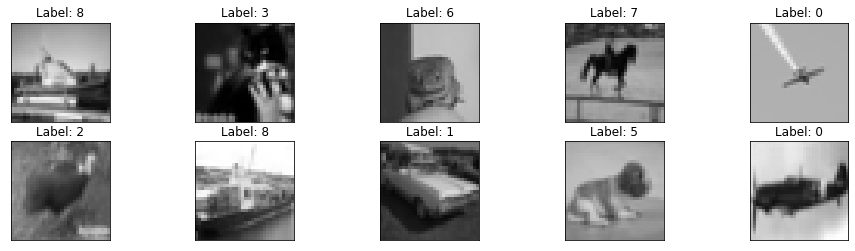

In [14]:
plot_sample_grey(10)

In [15]:
# extracts the layer from a model using the name
def get_layer_by_name(layers, name, return_first=True):
    matching_named_layers = [l for l in layers if l.name == name]
    if not matching_named_layers:
        return None
    return matching_named_layers[0] if return_first else matching_named_layers


In [ ]:
# # # let's do a dumb sequential and see how far this can go  

# def get_model_seq(input_shape):
#     model = Sequential([
#                 Flatten(name='F1',input_shape=input_shape),
#                 Dense(128, activation='relu', 
#                       name = 'D1'),
#                 Dense(128, activation='relu', name = 'D2'),
#                 Dense(48, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.005), name = 'D4R'),                
#                 Dense(10,  activation='softmax', name = 'SFTMX1')
#     ])    
#     return model

# model_seq = get_model_seq(train_data_grey[0,:,:,:].shape)

# model_seq.compile(optimizer=tf.keras.optimizers.Adam(),
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#               metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

# callbacks_seq = [ EarlyStopping(monitor='val_sparse_categorical_accuracy',
#                            mode='max',
#                            patience=60)
#                 ]

# history_seq = model_seq.fit(  train_data_grey, 
#                       train_targets,
#                       epochs=500, 
#                       validation_data=(validation_data_grey, validation_targets),
#                       callbacks=callbacks_seq,
#                       batch_size=512)

# model_seq.evaluate(test_data_grey,test_targets)
# model_seq.summary()

In [16]:
# plotting utilities for the history of the fit
def plot_history(history):
    acc_keys = [k for k in history.history.keys() if 'accuracy' in k]
    loss_keys = [k for k in history.history.keys() if not k in acc_keys]
    for k, v in history.history.items():
        if k in acc_keys:
            plt.figure(1)
            plt.plot(v)
        else:
            plt.figure(2)
            plt.plot(v)
    plt.figure(1)
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(acc_keys, loc='lower right')
    plt.figure(2)
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loss_keys, loc='upper right')
    plt.show()

def plot_history_df(history):
    acc_keys = [k for k in history.columns.values if 'accuracy' in k]
    loss_keys = [k for k in history.columns.values if not k in acc_keys and not k in ['epoch']]
    for k, v in history.items():
        if k in acc_keys:
            plt.figure(1)
            plt.plot(v)
        if k in loss_keys:
            plt.figure(2)
            plt.plot(v)
    plt.figure(1)
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(acc_keys, loc='lower right')
    plt.figure(2)
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loss_keys, loc='upper right')
    plt.show()   

# plot_history(history_seq)

A function that will take a model construction function (with _model_name_ and _input_shape_ arguments), train and fit it using the supplied data and callbacks. The _kwargs_ are supplied to the model fit function.

In [17]:
from tensorflow.keras.callbacks import CSVLogger
import datetime

def compile_and_fit_model_basic(  model_func,
                                  model_name,
                                  input_shape,
                                  X_train,
                                  Y_train,
                                  save_max_epoch=True,
                                  save_final=False,
                                  patience_count = None,
                                  early_stopping_obs = 'val_sparse_categorical_accuracy',
                                  log_history = True,
                                  verbose_level = 0,
                                  **kwargs):
    m = None
    if isinstance(model_func, tf.keras.models.Model):
        m = model_func
        m._name = model_name
    else:
        m = model_func(model_name, input_shape)
      
    if 'validation_data' not in kwargs.keys() and 'val_' in early_stopping_obs:
        early_stopping_obs = early_stopping_obs.replace('val_','')

    callbacks_used = []
    if save_max_epoch:
        callbacks_used.append(ModelCheckpoint(f'/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/{m.name}' + '_model_{epoch:03d}_{accuracy:0.3f}',
                                              save_weights_only=False,
                                              monitor = early_stopping_obs,
                                              mode='max',
                                              save_best_only=True))
    if patience_count is not None:
        callbacks_used.append(tf.keras.callbacks.EarlyStopping(monitor=early_stopping_obs, patience=patience_count))

    if log_history:
        callbacks_used.append(tf.keras.callbacks.CSVLogger(f"/content/drive/MyDrive/data_papers/{paper_name}/model_history/history_log_{model_name}_{datetime.date.today().strftime('%Y%m%d')}.csv", append=True))

    m.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              optimizer=tf.keras.optimizers.Adam(), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    
    history = m.fit(X_train, Y_train, callbacks=callbacks_used, verbose=verbose_level, **kwargs)
    if save_final:
        make_dir_if_not_exist(model_name)
        m.save(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{m.name}_saved_model_after_fit")  # Save the model
    return (m, history)

A function that given a model or model directory create a new model up to the _layer_name_, then write the features matching the supplied _X_ and _Y_ as numpy arrays to google drive.

In [18]:
def write_features_from_models(
        model_entry,
        layer_name,
        X_input, Y_input,
        reverse_one_hot=False,
        normalize_X_func=None,
        dataset_id = "NA",
        **kwargs):
  
    Y_new = None
    X_new = None
    if reverse_one_hot:
        Y_new = np.apply_along_axis(np.argmax, 1, Y_input) + 1
    else:
        Y_new = Y_input.copy()

    model_here = None
    if isinstance(model_entry, tf.keras.models.Model):
        model_here = model_entry
        model_file_name = model_here.name
    else:
        model_here = tf.keras.models.load_model(model_entry,**kwargs) 

    features_model = Model(model_here.input,
                            get_layer_by_name(model_here.layers, layer_name).output)
    if normalize_X_func is None:
        X_new = np.array(features_model.predict(X_input), dtype='float64')
    else:
        X_new = np.array(normalize_X_func(features_model.predict(X_input)), dtype='float64')

    np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/{model_here.name}_features_{layer_name}_{dataset_id}_X", X_new, 
               allow_pickle=True, 
               fix_imports=True)
    np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/{model_here.name}_features_{layer_name}_{dataset_id}_Y", Y_new, 
               allow_pickle=True, 
               fix_imports=True)

Some functions to get scores on the results

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def get_confusion_matrix_classification(model, X, Y_true):
    y_pred = model.predict(X)
    y_true = np.apply_along_axis(np.argmax, 1, Y_true)
    y_pred = np.apply_along_axis(np.argmax, 1, y_pred)
    return (confusion_matrix(y_true, y_pred), y_pred, y_true)

def construct_confusion_matrix(X, Y_true, Y_pred):
    y_true = Y_true
    y_pred = np.apply_along_axis(np.argmax, 1, Y_pred)
    return (confusion_matrix(y_true, y_pred), y_pred, y_true)

def pr_rc_f1_acc_from_supplied(y_pred, y_true):  
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")   
    acc = accuracy_score(y_true, y_pred)
    return pr, rc, f1, acc


utility function for checking file lists matching a regex in a directory

In [20]:
import re
import os

def dir_has_file_with_regex(dir_name, regex_string):
  filenames = [ f"{dir_name}/{dir_entry.name}" for dir_entry in os.scandir(dir_name) if os.path.isfile(f"{dir_name}/{dir_entry.name}") ]   
  filenames = [ fn for fn in filenames if re.match(regex_string, fn, re.IGNORECASE) ]
  return filenames


In [21]:
# dir_has_file_with_regex("/content/drive/MyDrive/data_papers/gpSVHN/model_features", "^.*DNN_A_.*D3R_Test_X.*")

# A basic DNN to fit CIFAR10

In [21]:
def basic_DNNTemplate_A(model_name, inshape, num_classes = 10):

  base_input = Input(shape=inshape, name='base_input')
  f1_output = Flatten(name='F1')(base_input)
  d1_output = Dense(128, activation='relu', name = 'D1')(f1_output)
  d2_output = Dense(128, activation='relu', name = 'D2')(d1_output)
  d3r_output = Dense(48, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.005), name = 'D3R')(d2_output)
  model_output = Dense(10,  activation='softmax', name = 'SFTMX1')(d3r_output)
  model = Model(base_input, model_output, name = model_name)

  return model

In [24]:
# train_data_grey[0,:,:,:].shape
# paper_name
# sys.version_info
# %timeit sum(range(100))
# %time sum(range(100))
f"DNN_A_TEST_{datetime.datetime.now():%Y%m%d%H%M%S}"

'DNN_A_TEST_20211106222126'

In [ ]:
# # saving 100 DNNs

import datetime

%time compile_and_fit_model_basic( basic_DNNTemplate_A, f"DNN_A_TEST_{datetime.datetime.now():%Y%m%d%H%M%S}", train_data_grey[0,:,:,:].shape, train_data_grey, train_targets, save_max_epoch=False, save_final=True, patience_count = 35, early_stopping_obs = 'val_sparse_categorical_accuracy', log_history = True,  batch_size=512, epochs=250, class_weight=None, verbose_level=1,validation_data=(validation_data_grey, validation_targets))
# 25s

for model_count in [i+1 for i in range(100)]:
  print(model_count)
  m1, h1 = compile_and_fit_model_basic( basic_DNNTemplate_A,  
                    f"DNN_A_{str(model_count)}_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                    train_data_grey[0,:,:,:].shape, 
                    train_data_grey, train_targets,
                    save_max_epoch=False,
                    save_final=True,
                    patience_count = 35,
                    early_stopping_obs = 'val_sparse_categorical_accuracy',
                    log_history = True,                             
                    batch_size=512, 
                    epochs=250, 
                    class_weight=None, 
                    verbose_level=1,
                    validation_data=(validation_data_grey, validation_targets))



In [ ]:
# saving the features of 100 DNNs for the train data

check_model_string = "DNN_A_"
not_check_model_string = ["arallel","Collab_"]
for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([(not ncs in dir_entry.name) for ncs in not_check_model_string]):
      # f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/{model_here.name}_features_{layer_name}_{dataset_id}_X"
      # f"DNN_A_{str(model_count)}_{datetime.datetime.now():%Y%m%d%H%M%S}"
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_D3R_Train.*$"):
        print(dir_entry.name)
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "D3R",
          train_data_grey, train_targets,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Train")
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_SFTMX1_Train.*$"):
        print(dir_entry.name)
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "SFTMX1",
          train_data_grey, train_targets,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Train")   

In [ ]:
# saving the features of 100 DNNs for the validation data
check_model_string = "DNN_A_"
not_check_model_string = ["arallel","Collab_"]
for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([(not ncs in dir_entry.name) for ncs in not_check_model_string]):
      # f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/{model_here.name}_features_{layer_name}_{dataset_id}_X"
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_D3R_Validation.*$"):
        print(dir_entry.name)
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "D3R",
          validation_data_grey, validation_targets,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Validation")
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_SFTMX1_Validation.*$"):
        print(dir_entry.name)
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "SFTMX1",
          validation_data_grey, validation_targets,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Validation")  

In [ ]:
# saving the features of 100 DNNs for the test data
check_model_string = "DNN_A_"
not_check_model_string = ["arallel","Collab_"]
for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([(not ncs in dir_entry.name) for ncs in not_check_model_string]):
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name}.*_features_D3R_Test.*$"):
        print(dir_entry.name)
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "D3R",
          test_data_grey, test_targets,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Test")
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name}.*_features_SFTMX1_Test.*$"):
        print(dir_entry.name)
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "SFTMX1",
          test_data_grey, test_targets,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Test") 

In [ ]:
# getting the scores for the individual 100 DNNs on the test data set
scores_dnn_simple = []
check_model_string = "DNN_A_"
not_check_model_string = ["arallel","Collab_"]
for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([ (not ncs in dir_entry.name) for ncs in not_check_model_string]):
      print(dir_entry.name)
      model_here = tf.keras.models.load_model(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}")  
      y_predict_here = np.array(model_here.predict(test_data_grey), dtype='float64')
      y_predict_here = np.apply_along_axis(np.argmax, 1, y_predict_here)
      scores_dnn_simple.append(pr_rc_f1_acc_from_supplied(y_predict_here, test_targets))

np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/individual_dnn_summary_{datetime.datetime.now():%Y%m%d%H%M%S}", np.array(scores_dnn_simple), 
               allow_pickle=True, 
               fix_imports=True)



# A basic CNN to fit CIFAR10


In [22]:
def basic_CNNTemplate_A(model_name, inshape, num_classes = 10):
  # Input Layer
  base_input = Input(shape=inshape, name='base_input')
  # Convolutional Layer #1
  c1_output = Conv2D(filters=32,kernel_size=[5, 5],padding="same",activation="relu", name="C1")(base_input)

  # Pooling Layer #1
  mxp1_output = MaxPooling2D(pool_size=[2, 2], strides=2, name="MXP1")(c1_output)
  c2_output = Conv2D(filters=64,kernel_size=[5, 5],padding="same",activation="relu",name="C2")(mxp1_output)
    
  #with tf.name_scope('Pool2 Layer'):
  mxp2_output = MaxPooling2D(pool_size=[2, 2], strides=2, name="MXP2")(c2_output)
  f1_output = Flatten(name='F1')(mxp2_output)

  # Dense Layer
  d1_output = Dense(units=256, activation="relu", name="D1")(f1_output)
  drp1_output = Dropout(rate=0.5, name="DRP1")(d1_output)

  model_output = Dense(num_classes,  activation='softmax', name = 'SFTMX1')(drp1_output)
  model = Model(base_input, model_output, name = model_name)
  return model


In [ ]:
# # saving 100 CNNs
for model_count in [i+1 for i in range(100)]:
  print(model_count)
  m1, h1 = compile_and_fit_model_basic( basic_CNNTemplate_A,  
                    f"CNN_A_{str(model_count)}_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                    train_data_grey[0,:,:,:].shape, 
                    train_data_grey, train_targets,
                    save_max_epoch=False,
                    save_final=True,
                    patience_count = 35,
                    early_stopping_obs = 'val_sparse_categorical_accuracy',
                    log_history = True,                             
                    batch_size=512, 
                    epochs=250, 
                    class_weight=None, 
                    # verbose_level=1,
                    validation_data=(validation_data_grey, validation_targets))


# plot_history(h1)

In [ ]:
# # saving the features of 100 CNNs for the training data

check_model_string = "CNN_A_"
not_check_model_string = ["arallel","Collab_"]
for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([ (not ncs in dir_entry.name) for ncs in not_check_model_string]):
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_DRP1_Train.*$"):
        print(dir_entry.name)
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "DRP1",
          train_data_grey, train_targets,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Train")
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_SFTMX1_Train.*$"):
        print(dir_entry.name)
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "SFTMX1",
          train_data_grey, train_targets,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Train")    

In [ ]:
# # saving the features of 100 CNNs for the Validation data

check_model_string = "CNN_A_"
not_check_model_string = ["arallel","Collab_"]
for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([ (not ncs in dir_entry.name) for ncs in not_check_model_string]):
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_DRP1_Validation.*$"):
        print(dir_entry.name)
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "DRP1",
          validation_data_grey, validation_targets,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Validation")
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_SFTMX1_Validation.*$"):
        print(dir_entry.name)
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "SFTMX1",
          validation_data_grey, validation_targets,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Validation")  

In [ ]:
# # saving the features of 100 CNNs for the Test data

check_model_string = "CNN_A_"
not_check_model_string = ["arallel","Collab_"]
for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([ (not ncs in dir_entry.name) for ncs in not_check_model_string]):
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_DRP1_Test.*$"):
        print(dir_entry.name)
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "DRP1",
          test_data_grey, test_targets,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Test")
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_SFTMX1_Test.*$"):
        print(dir_entry.name)
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "SFTMX1",
          test_data_grey, test_targets,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Test")   

In [ ]:
# getting the scores for the individual 100 CNNs on the test data set
scores_cnn_simple = []
check_model_string = "CNN_A_"
not_check_model_string = ["arallel","Collab_"]
for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([ (not ncs in dir_entry.name) for ncs in not_check_model_string]):
      print(dir_entry.name)
      model_here = tf.keras.models.load_model(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}")  
      y_predict_here = np.array(model_here.predict(test_data_grey), dtype='float64')
      y_predict_here = np.apply_along_axis(np.argmax, 1, y_predict_here)
      scores_cnn_simple.append(pr_rc_f1_acc_from_supplied(y_predict_here, test_targets))

np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/individual_cnn_summary_{datetime.datetime.now():%Y%m%d%H%M%S}", np.array(scores_cnn_simple), 
               allow_pickle=True, 
               fix_imports=True)



# ResNet50 fit CIFAR10 grey

In [23]:
# from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization


In [24]:
def basic_ResNet50Template_A(model_name, inshape, num_classes = 10):
  model = Sequential(name=model_name)
  model.add(ResNet50(include_top=True, pooling='avg', weights=None,input_shape=inshape, classes=num_classes))
  model.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam',      
                metrics=['acc'])
  return(model)

def basic_VGG19Template_A(model_name, inshape, num_classes = 10):
  model = Sequential(name=model_name)
  model.add(VGG19(include_top=True, pooling='avg', weights=None,input_shape=inshape, classes=num_classes))
  model.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam',      
                metrics=['acc'])
  return(model)



In [ ]:
# # saving 100 RestNet50
for model_count in [i for i in range(3)]:
  m1, h1 = compile_and_fit_model_basic( basic_ResNet50Template_A,  
                    f"RestNet50_A_{str(model_count+37)}_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                    train_data_grey[0,:,:,:].shape, 
                    train_data_grey, train_targets,
                    save_max_epoch=False,
                    save_final=True,
                    patience_count = 35,
                    early_stopping_obs = 'val_sparse_categorical_accuracy',
                    log_history = True,                             
                    batch_size=512, 
                    epochs=250, 
                    class_weight=None, 
                    verbose_level = 1,
                    validation_data=(validation_data_grey, validation_targets))

In [28]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
# plot_model(m1)

In [ ]:
# getting the scores for the individual 40 ResNets on the test data set
scores_resnets_simple = []
check_model_string = "RestNet50_A"
not_check_model_string = ["arallel","Collab_"]
for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([ (not ncs in dir_entry.name) for ncs in not_check_model_string]):
      print(dir_entry.name)
      model_here = tf.keras.models.load_model(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}")  
      y_predict_here = np.array(model_here.predict(test_data_grey), dtype='float64')
      y_predict_here = np.apply_along_axis(np.argmax, 1, y_predict_here)
      scores_resnets_simple.append(pr_rc_f1_acc_from_supplied(y_predict_here, test_targets))

np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/individual_resnets_summary_{datetime.datetime.now():%Y%m%d%H%M%S}", np.array(scores_resnets_simple), 
               allow_pickle=True, 
               fix_imports=True)

# WideResNet fit CIFAR10 grey

In [25]:
import uuid
# uuid.uuid4()
# str(uuid.uuid4()).split("-")[0]

In [26]:
# https://github.com/asmith26/wide_resnets_keras

# Wide residual network http://arxiv.org/abs/1605.07146
def _wide_basic(n_input_plane, n_output_plane, stride, identifier, 
                channel_axis = -1,
                weight_decay = 0.0005,
                weight_init="he_normal",
                use_bias = False,
                dropout_probability = 0.0
                ):
    def f(net):
        # format of conv_params:
        #               [ [nb_col="kernel width", nb_row="kernel height",
        #               subsample="(stride_vertical,stride_horizontal)",
        #               border_mode="same" or "valid"] ]
        # B(3,3): orignal <<basic>> block
        conv_params = [ [3,3,stride,"same"],
                        [3,3,(1,1),"same"] ]
        
        n_bottleneck_plane = n_output_plane

        # Residual block
        for i, v in enumerate(conv_params):
            if i == 0:
                if n_input_plane != n_output_plane:
                    net = BatchNormalization(axis=channel_axis, name=f"BN{str(i)}_{identifier}_{uuid.uuid4()}")(net)
                    net = Activation("relu")(net)
                    convs = net
                else:
                    convs = BatchNormalization(axis=channel_axis, name=f"BN{str(i)}_{identifier}_{uuid.uuid4()}")(net)
                    convs = Activation("relu")(convs)
                convs = Conv2D(n_bottleneck_plane, 
                               (v[0],v[1]),
                                strides=v[2],
                                padding=v[3],
                                kernel_initializer=weight_init,
                                kernel_regularizer=L2(weight_decay),
                                use_bias=use_bias,
                                name = f"CONV0_{identifier}_{uuid.uuid4()}")(convs)
            else:
                convs = BatchNormalization(axis=channel_axis, name=f"BN{str(i)}_{identifier}_{uuid.uuid4()}")(convs)
                convs = Activation("relu")(convs)
                if dropout_probability > 0:
                   convs = Dropout(dropout_probability, name=f"DRP{str(i)}_{identifier}_{uuid.uuid4()}")(convs)
                convs = Conv2D(n_bottleneck_plane, 
                               (v[0],v[1]),
                                strides=v[2],
                                padding=v[3],
                                kernel_initializer=weight_init,
                                kernel_regularizer=L2(weight_decay),
                                use_bias=use_bias,
                                name=f"CONV{str(i)}_{identifier}_{uuid.uuid4()}")(convs)

        # Shortcut Conntection: identity function or 1x1 convolutional
        #  (depends on difference between input & output shape - this
        #   corresponds to whether we are using the first block in each
        #   group; see _layer() ).
        if n_input_plane != n_output_plane:
            shortcut = Conv2D(n_output_plane, 
                              (1,1),
                              strides=stride,
                              padding="same",
                              kernel_initializer=weight_init,
                              kernel_regularizer=L2(weight_decay),
                              use_bias=use_bias,
                              name=f"CONVSHORTCUT_{identifier}_{uuid.uuid4()}")(net)
        else:
            shortcut = net

        return Add()([convs, shortcut])
    
    return f


# "Stacking Residual Units on the same stage"
def _layer(block, n_input_plane, n_output_plane, count, stride):
    def f(net):
        net = block(n_input_plane, n_output_plane, stride)(net)
        for i in range(2,int(count+1)):
            net = block(n_output_plane, n_output_plane, stride=(1,1))(net)
        return net
    
    return f


This will be WRN-28-10 WideResNet

In [27]:
input_shape=train_data_grey[0,:,:,:].shape
weight_decay = 0.0005
weight_init="he_normal"
use_bias = False
k = 10
depth = 28             
n = (depth - 4) / 6
dropout_probability = 0.0
# batch_size = 128      
# nb_epochs = 200
channel_axis = -1

num_wrn_models = 5
no_classes=10
import functools

In [28]:
# set up WRN-28-10 models 
model_wrns = []

for i in [ j+6 for j in range(num_wrn_models) ]:
  inputs_wrn = Input(shape=input_shape,name=f"M{str(i)}_INPUT")
  n_stages=[16, 16*k, 32*k, 64*k]
  conv1_wrn = Conv2D(16, 
                  (3, 3), 
                  strides=1,
                  padding="same",
                  kernel_initializer=weight_init,
                  kernel_regularizer=L2(weight_decay),
                  use_bias=use_bias,
                  name="C1BLOCK")(inputs_wrn) # "One conv at the beginning (spatial size: 32x32)"
  # Add wide residual blocks
  block_fn = _wide_basic
  conv2_wrn = _layer(functools.partial(block_fn,identifier=f"C2BLOCK"), n_input_plane=n_stages[0], n_output_plane=n_stages[1], count=n, stride=(1,1))(conv1_wrn)# "Stage 1 (spatial size: 32x32)"
  conv3_wrn = _layer(functools.partial(block_fn,identifier=f"C3BLOCK"), n_input_plane=n_stages[1], n_output_plane=n_stages[2], count=n, stride=(2,2))(conv2_wrn)# "Stage 2 (spatial size: 16x16)"
  conv4_wrn = _layer(functools.partial(block_fn,identifier=f"C4BLOCK"), n_input_plane=n_stages[2], n_output_plane=n_stages[3], count=n, stride=(2,2))(conv3_wrn)# "Stage 3 (spatial size: 8x8)"

  batch_norm_wrn = BatchNormalization(axis=channel_axis,name=f"M{str(i)}_BN")(conv4_wrn)
  relu_wrn = Activation("relu")(batch_norm_wrn)
                                          
  # Classifier block
  pool_wrn = AveragePooling2D(pool_size=(8, 8), strides=(1, 1), padding="same", name=f"CLASSIFIER_AVPL")(relu_wrn)
  flatten_wrn = Flatten(name=f"CLASSIFIER_FL")(pool_wrn)
  predictions_wrn = Dense(units=no_classes, kernel_initializer=weight_init, use_bias=use_bias,
                      kernel_regularizer=L2(weight_decay), activation="softmax", name="CLASSIFIER_D1")(flatten_wrn)
  model_wrn = Model(inputs=inputs_wrn, outputs=predictions_wrn)
  model_wrns.append(model_wrn)




In [29]:
from tensorflow.keras.utils import plot_model
# plot_model(model_wrns[0])


In [30]:
for model_count in [i+6 for i in range(len(model_wrns))]:
  mwrn, hwrn = compile_and_fit_model_basic(  model_wrns[model_count-6], 
                                           f"WideResNet28-10_ID{str(uuid.uuid4()).split('-')[0]}_{str(model_count+1)}_{datetime.datetime.now():%Y%m%d%H%M%S}",
                                          train_data_grey[0,:,:,:].shape,
                                          train_data_grey,
                                          train_targets,
                                          save_max_epoch=False,
                                          save_final=True,
                                          patience_count = 35,
                                          early_stopping_obs = 'val_sparse_categorical_accuracy',
                                          log_history = True,
                                          verbose_level = 1,
                                          batch_size=256, 
                                          epochs=250, 
                                          class_weight=None,
                                          validation_data=(validation_data_grey, validation_targets))


Epoch 1/250
157/157 [==============================] - 119s 620ms/step - loss: 9.3284 - sparse_categorical_accuracy: 0.2273 - val_loss: 7.0020 - val_sparse_categorical_accuracy: 0.2261
Epoch 2/250
157/157 [==============================] - 96s 613ms/step - loss: 4.6161 - sparse_categorical_accuracy: 0.4634 - val_loss: 5.0526 - val_sparse_categorical_accuracy: 0.2189
Epoch 3/250
157/157 [==============================] - 96s 613ms/step - loss: 3.2099 - sparse_categorical_accuracy: 0.5828 - val_loss: 3.9568 - val_sparse_categorical_accuracy: 0.3070
Epoch 4/250
157/157 [==============================] - 97s 615ms/step - loss: 2.5263 - sparse_categorical_accuracy: 0.6416 - val_loss: 2.9930 - val_sparse_categorical_accuracy: 0.3859
Epoch 5/250
157/157 [==============================] - 96s 613ms/step - loss: 2.1017 - sparse_categorical_accuracy: 0.6859 - val_loss: 2.3483 - val_sparse_categorical_accuracy: 0.5714
Epoch 6/250
157/157 [==============================] - 96s 614ms/step - loss: 1

INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/gpCIFAR10/model_finals/WideResNet28-10_ID8f962647_7_20211107225902_saved_model_after_fit/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/gpCIFAR10/model_finals/WideResNet28-10_ID8f962647_7_20211107225902_saved_model_after_fit/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/250
157/157 [==============================] - 100s 617ms/step - loss: 8.7998 - sparse_categorical_accuracy: 0.2807 - val_loss: 5.9364 - val_sparse_categorical_accuracy: 0.2153
Epoch 2/250
157/157 [==============================] - 96s 610ms/step - loss: 4.1377 - sparse_categorical_accuracy: 0.4907 - val_loss: 4.1544 - val_sparse_categorical_accuracy: 0.3168
Epoch 3/250
157/157 [==============================] - 96s 611ms/step - loss: 2.9026 - sparse_categorical_accuracy: 0.5784 - val_loss: 2.9321 - val_sparse_categorical_accuracy: 0.4556
Epoch 4/250
157/157 [==============================] - 96s 611ms/step - loss: 2.3084 - sparse_categorical_accuracy: 0.6302 - val_loss: 2.4795 - val_sparse_categorical_accuracy: 0.5377
Epoch 5/250
157/157 [==============================] - 96s 612ms/step - loss: 1.8924 - sparse_categorical_accuracy: 0.6877 - val_loss: 1.9675 - val_sparse_categorical_accuracy: 0.6209
Epoch 6/250
157/157 [==============================] - 96s 614ms/step - loss: 1

INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/gpCIFAR10/model_finals/WideResNet28-10_ID113b4849_8_20211108002852_saved_model_after_fit/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/gpCIFAR10/model_finals/WideResNet28-10_ID113b4849_8_20211108002852_saved_model_after_fit/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/250
157/157 [==============================] - 100s 617ms/step - loss: 9.3007 - sparse_categorical_accuracy: 0.2189 - val_loss: 6.4933 - val_sparse_categorical_accuracy: 0.1155
Epoch 2/250
157/157 [==============================] - 96s 612ms/step - loss: 4.5922 - sparse_categorical_accuracy: 0.4055 - val_loss: 3.9957 - val_sparse_categorical_accuracy: 0.3654
Epoch 3/250
157/157 [==============================] - 96s 613ms/step - loss: 3.1946 - sparse_categorical_accuracy: 0.5200 - val_loss: 2.8494 - val_sparse_categorical_accuracy: 0.5359
Epoch 4/250
157/157 [==============================] - 96s 613ms/step - loss: 2.4317 - sparse_categorical_accuracy: 0.6127 - val_loss: 2.7447 - val_sparse_categorical_accuracy: 0.4735
Epoch 5/250
157/157 [==============================] - 96s 612ms/step - loss: 1.9845 - sparse_categorical_accuracy: 0.6653 - val_loss: 2.6745 - val_sparse_categorical_accuracy: 0.4544
Epoch 6/250
157/157 [==============================] - 96s 614ms/step - loss: 1

INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/gpCIFAR10/model_finals/WideResNet28-10_ID6e13a9ca_9_20211108042434_saved_model_after_fit/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/gpCIFAR10/model_finals/WideResNet28-10_ID6e13a9ca_9_20211108042434_saved_model_after_fit/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/250
157/157 [==============================] - 100s 616ms/step - loss: 9.3479 - sparse_categorical_accuracy: 0.2483 - val_loss: 6.3510 - val_sparse_categorical_accuracy: 0.2313
Epoch 2/250
157/157 [==============================] - 96s 613ms/step - loss: 4.4912 - sparse_categorical_accuracy: 0.4550 - val_loss: 4.7104 - val_sparse_categorical_accuracy: 0.2481
Epoch 3/250
157/157 [==============================] - 96s 612ms/step - loss: 3.0240 - sparse_categorical_accuracy: 0.5574 - val_loss: 4.2972 - val_sparse_categorical_accuracy: 0.2492
Epoch 4/250
157/157 [==============================] - 96s 612ms/step - loss: 2.3573 - sparse_categorical_accuracy: 0.6153 - val_loss: 2.2918 - val_sparse_categorical_accuracy: 0.5872
Epoch 5/250
157/157 [==============================] - 96s 613ms/step - loss: 1.9412 - sparse_categorical_accuracy: 0.6601 - val_loss: 2.4112 - val_sparse_categorical_accuracy: 0.4678
Epoch 6/250
157/157 [==============================] - 96s 612ms/step - loss: 1

INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/gpCIFAR10/model_finals/WideResNet28-10_ID7fe42828_10_20211108062237_saved_model_after_fit/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/gpCIFAR10/model_finals/WideResNet28-10_ID7fe42828_10_20211108062237_saved_model_after_fit/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/250
157/157 [==============================] - 100s 616ms/step - loss: 8.7072 - sparse_categorical_accuracy: 0.2639 - val_loss: 5.8719 - val_sparse_categorical_accuracy: 0.2386
Epoch 2/250
157/157 [==============================] - 96s 612ms/step - loss: 4.1012 - sparse_categorical_accuracy: 0.4566 - val_loss: 4.0126 - val_sparse_categorical_accuracy: 0.2880
Epoch 3/250
157/157 [==============================] - 96s 612ms/step - loss: 2.8315 - sparse_categorical_accuracy: 0.5640 - val_loss: 2.8123 - val_sparse_categorical_accuracy: 0.4593
Epoch 4/250
157/157 [==============================] - 96s 612ms/step - loss: 2.1961 - sparse_categorical_accuracy: 0.6316 - val_loss: 2.5395 - val_sparse_categorical_accuracy: 0.4751
Epoch 5/250
157/157 [==============================] - 96s 612ms/step - loss: 1.8446 - sparse_categorical_accuracy: 0.6719 - val_loss: 2.0784 - val_sparse_categorical_accuracy: 0.5842
Epoch 6/250
157/157 [==============================] - 96s 612ms/step - loss: 1

INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/gpCIFAR10/model_finals/WideResNet28-10_IDd1ab6d89_11_20211108091739_saved_model_after_fit/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/gpCIFAR10/model_finals/WideResNet28-10_IDd1ab6d89_11_20211108091739_saved_model_after_fit/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
# # saving the features of WideResNets for the training data

check_model_string = "WideResNet28-10_"
not_check_model_string = ["arallel","Collab_"]

acceptable_chunk = 5000
idxs_for_train = np.unique(list(range(0,train_data_grey.shape[0],acceptable_chunk)) + [train_data_grey.shape[0]]).tolist()

for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([ (not ncs in dir_entry.name) for ncs in not_check_model_string]):
      for i in range(len(idxs_for_train[:-1])):
        print(f"{dir_entry.name}_{idxs_for_train[i]}-{idxs_for_train[i+1]}")
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "CLASSIFIER_FL",
          train_data_grey[idxs_for_train[i]:idxs_for_train[i+1],:,:,:], train_targets[idxs_for_train[i]:idxs_for_train[i+1],:],
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id=f"Train{str(i)}_{idxs_for_train[i]}-{idxs_for_train[i+1]}")
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "CLASSIFIER_D1",
          train_data_grey[idxs_for_train[i]:idxs_for_train[i+1],:,:,:], train_targets[idxs_for_train[i]:idxs_for_train[i+1],:],
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id=f"Train{str(i)}_{idxs_for_train[i]}-{idxs_for_train[i+1]}")

In [ ]:
# # saving the features of WideResNets for the Validation data  

check_model_string = "WideResNet28-10_"
not_check_model_string = ["arallel","Collab_"]

acceptable_chunk = 5000
idxs_for_validation = np.unique(list(range(0,validation_data_grey.shape[0],acceptable_chunk)) + [validation_data_grey.shape[0]]).tolist()

for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([ (not ncs in dir_entry.name) for ncs in not_check_model_string]):
      for i in range(len(idxs_for_validation[:-1])):
        print(f"{dir_entry.name}__{idxs_for_validation[i]}-{idxs_for_validation[i+1]}")
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "CLASSIFIER_FL",
          validation_data_grey[idxs_for_validation[i]:idxs_for_validation[i+1],:,:,:], validation_targets[idxs_for_validation[i]:idxs_for_validation[i+1],:],
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id=f"Validation{str(i)}_{idxs_for_validation[i]}-{idxs_for_validation[i+1]}")     
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "CLASSIFIER_D1",
          validation_data_grey[idxs_for_validation[i]:idxs_for_validation[i+1],:,:,:], validation_targets[idxs_for_validation[i]:idxs_for_validation[i+1],:],
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id=f"Validation{str(i)}_{idxs_for_validation[i]}-{idxs_for_validation[i+1]}")     
      

In [ ]:
# # saving the features of WideResNets for the Test data  

check_model_string = "WideResNet28-10_"
not_check_model_string = ["arallel","Collab_"] 

acceptable_chunk = 5000
idxs_for_test = np.unique(list(range(0,test_data_grey.shape[0],acceptable_chunk)) + [test_data_grey.shape[0]]).tolist()

for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([ (not ncs in dir_entry.name) for ncs in not_check_model_string]):
      for i in range(len(idxs_for_test[:-1])):
      # # saving the features of WideResNets for the Test data      
        print(f"{dir_entry.name}__{idxs_for_test[i]}-{idxs_for_test[i+1]}")
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "CLASSIFIER_FL",
          test_data_grey[idxs_for_test[i]:idxs_for_test[i+1],:,:,:], test_targets[idxs_for_test[i]:idxs_for_test[i+1],:],
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id=f"TestBatch{str(i)}_{idxs_for_test[i]}-{idxs_for_test[i+1]}")      
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "CLASSIFIER_D1",
          test_data_grey[idxs_for_test[i]:idxs_for_test[i+1],:,:,:], test_targets[idxs_for_test[i]:idxs_for_test[i+1],:],
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id=f"TestBatch{str(i)}_{idxs_for_test[i]}-{idxs_for_test[i+1]}")

In [ ]:
# getting the scores for the individual WideResNets on the test data set
scores_wideresnets_simple = []
check_model_string = "WideResNet28-10_"
not_check_model_string = ["arallel","Collab_"]
for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([ (not ncs in dir_entry.name) for ncs in not_check_model_string]):
      print(dir_entry.name)
      model_here = tf.keras.models.load_model(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}")  
      y_predict_here = np.array(model_here.predict(test_data_grey), dtype='float64')
      y_predict_here = np.apply_along_axis(np.argmax, 1, y_predict_here)
      print(pr_rc_f1_acc_from_supplied(y_predict_here, test_targets))
      scores_wideresnets_simple.append(pr_rc_f1_acc_from_supplied(y_predict_here, test_targets))

np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/individual_WideResNet2810_summary_{datetime.datetime.now():%Y%m%d%H%M%S}", np.array(scores_wideresnets_simple), 
               allow_pickle=True, 
               fix_imports=True)  

# Set up the models, CNN/DNN/ResNet50/WideResNet28-10 splits for reuse CIFAR10

In [ ]:
acceptable_string_grabs = [ "CNN_A_", "DNN_A_", "RestNet50_A_", "WideResNet28-10_ID"]
not_check_model_string = ["arallel","Collab_"]

model_dirs = [  f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}" 
                for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/") 
                if os.path.isdir(dir_entry) and any(xs in dir_entry.name for xs in acceptable_string_grabs) ]
dnn_model_dirs = [ s for s in model_dirs if "DNN" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 
cnn_model_dirs = [ s for s in model_dirs if "CNN" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 
resnets_model_dirs = [ s for s in model_dirs if "RestNet50" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 
wideresnets_model_dirs = [ s for s in model_dirs if "WideResNet" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 

model_features_files = [  f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/{file_entry.name}" 
                for file_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/") 
                if os.path.isfile(file_entry) and any(xs in file_entry.name for xs in acceptable_string_grabs) ]

dnn_features_files = [ s for s in model_features_files if "DNN" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 
cnn_features_files = [ s for s in model_features_files if "CNN" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 
resnets_features_files = [ s for s in model_features_files if "RestNet50" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 
wideresnets_features_files = [ s for s in model_features_files if "WideResNet" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 

dnn_identifier = acceptable_string_grabs[1]
dnn_layer_name = "DRP1"

cnn_identifier = acceptable_string_grabs[0]
cnn_layer_name = "D3R"

wideresnet_identifier = acceptable_string_grabs[3]
wideresnet_layer_name = "CLASSIFIER_FL"


def avgfilter_ensemble_predictions(y_pred_ms, xtest):
  y_preds_ens_prb = np.apply_along_axis(np.mean, 0, y_pred_ms)
  y_preds_ens_idx = np.apply_along_axis(np.argmax, 1, y_preds_ens_prb) 
  # y_preds_ens_idx = y_preds_ens_idx + 1
  return y_preds_ens_idx




# Set up ensembles of 20 DNN, 20 CNN or 10 CNN/10 DNN to predict (randomly assembled from the 100 before)

In [ ]:
num_of_repeats = 20
num_of_models = 20

x_input = validation_data_grey
y_input = validation_targets

# create traditional ensemble of 20 DNNs 
scores_dnn20 = []
for repc in range(num_of_repeats):
  dnn_models_to_use = [ tf.keras.models.load_model(mfile) for mfile in sorted(random.sample(dnn_model_dirs, num_of_models))]
  dnn_model_predictions = [ model.predict(x_input) for model in dnn_models_to_use]
  y_ens_preds = avgfilter_ensemble_predictions(dnn_model_predictions, x_input)
  scores_dnn20.append(pr_rc_f1_acc_from_supplied(y_ens_preds,y_input))

# create traditional ensemble of 20 CNNs 
scores_cnn20 = []
for repc in range(num_of_repeats):
  cnn_models_to_use = [ tf.keras.models.load_model(mfile) for mfile in sorted(random.sample(cnn_model_dirs, num_of_models))]
  cnn_model_predictions = [ model.predict(x_input) for model in cnn_models_to_use]
  y_ens_preds = avgfilter_ensemble_predictions(cnn_model_predictions, x_input)
  scores_cnn20.append(pr_rc_f1_acc_from_supplied(y_ens_preds,y_input))




In [ ]:
num_of_repeats = 20
num_of_models = 20

x_input = validation_data_grey
y_input = validation_targets

# create traditional ensemble of 10 CNNs and 10 DNNs
scores_cnn10dnn10 = []
for repc in range(num_of_repeats):
  cnn_models_to_use = [ tf.keras.models.load_model(mfile) for mfile in sorted(random.sample(cnn_model_dirs, int(num_of_models/2)))]
  cnn_model_predictions = [ model.predict(x_input) for model in cnn_models_to_use]
  dnn_models_to_use = [ tf.keras.models.load_model(mfile) for mfile in sorted(random.sample(dnn_model_dirs, int(num_of_models/2)))]
  models_to_use = cnn_models_to_use
  models_to_use.extend(dnn_models_to_use)
  model_predictions = [ model.predict(x_input) for model in models_to_use]
  y_ens_preds = avgfilter_ensemble_predictions(model_predictions, x_input)
  scores_cnn10dnn10.append(pr_rc_f1_acc_from_supplied(y_ens_preds,y_input))



Save the score results of the ensembles

In [ ]:
np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/traditional_ensemble_dnn20_summary_{datetime.datetime.now():%Y%m%d%H%M%S}", np.array(scores_dnn20), 
               allow_pickle=True, 
               fix_imports=True)
np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/traditional_ensemble_cnn20_summary_{datetime.datetime.now():%Y%m%d%H%M%S}", np.array(scores_cnn20), 
               allow_pickle=True, 
               fix_imports=True)
np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/traditional_ensemble_cnn10dnn10_summary_{datetime.datetime.now():%Y%m%d%H%M%S}", np.array(scores_cnn10dnn10), 
               allow_pickle=True, 
               fix_imports=True)



# Set up ensembles of 20 ResNets50 (randomly assembled from the 40 before) and 10 WideResNets

In [ ]:
num_of_repeats = 10
num_of_models = 20

x_input = validation_data_grey
y_input = validation_targets

# create traditional ensemble of 20 resnets 
scores_resnets = []
for repc in range(num_of_repeats):
  print(repc)
  resnets_models_to_use = [ tf.keras.models.load_model(mfile) for mfile in sorted(random.sample(resnets_model_dirs, num_of_models))]
  resnets_model_predictions = [ model.predict(x_input) for model in resnets_models_to_use]
  y_ens_preds = avgfilter_ensemble_predictions(resnets_model_predictions, x_input)
  scores_resnets.append(pr_rc_f1_acc_from_supplied(y_ens_preds,y_input))
  del resnets_models_to_use
  del resnets_model_predictions
  del y_ens_preds


# create a traditional ensemble of 10 wideresnets 
scores_wideresnets = []
for repc in range(1):
  print(repc)
  wideresnets_models_to_use = [ tf.keras.models.load_model(mfile) for mfile in sorted(random.sample(wideresnets_model_dirs, 10))]
  wideresnets_model_predictions = [ model.predict(x_input) for model in wideresnets_models_to_use]
  y_ens_preds = avgfilter_ensemble_predictions(wideresnets_model_predictions, x_input)
  scores_wideresnets.append(pr_rc_f1_acc_from_supplied(y_ens_preds,y_input))




Save the score results of the ensembles resnets and wideResNets

In [ ]:
np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/traditional_ensemble_resnets_summary_{datetime.datetime.now():%Y%m%d%H%M%S}", np.array(scores_resnets), 
               allow_pickle=True, 
               fix_imports=True)
np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/traditional_ensemble_wideresnet28-10_summary_{datetime.datetime.now():%Y%m%d%H%M%S}", np.array(scores_wideresnets), 
               allow_pickle=True, 
               fix_imports=True)



# Parallel model with no GP and no collaborative but with different parallel DNN/CNN streams. The _best_ parallel model.

function for basic parallel 20 DNN

In [ ]:
def basic_ParallelDNN_A(model_name, inshape, num_classes = 10, num_of_parallels = 20):

  base_input = Input(shape=inshape, name='base_input')
  f1_output = Flatten(name='F1')(base_input)

  d3rs = []
  for pc in range(num_of_parallels):
    d1_output = Dense(128, activation='relu', name = f'p{pc+1}_D1')(f1_output)
    d2_output = Dense(128, activation='relu', name = f'p{pc+1}_D2')(d1_output)
    d3r_output = Dense(48, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.005), name = f'p{pc+1}_D3R')(d2_output)
    d3rs.append(d3r_output)

  # merging_layer = tf.keras.layers.concatenate(d3rs)
  concat1_output = Concatenate(name="CONCAT1")(d3rs)
  model_output = Dense(num_classes,  activation='softmax', name = 'SFTMX1')(concat1_output)
  model = Model(base_input, model_output, name = model_name)

  return model

function for basic parallel 20 CNN

In [ ]:
def basic_ParallelCNN_A(model_name, inshape, num_classes = 10, num_of_parallels = 20):

  # Input Layer
  base_input = Input(shape=inshape, name='base_input')

  drp1s = []
  for pc in range(num_of_parallels):
    c1_output = Conv2D(filters=32,kernel_size=[5, 5],padding="same",activation="relu", name=f"p{pc+1}_C1")(base_input)
    mxp1_output = MaxPooling2D(pool_size=[2, 2], strides=2, name=f"p{pc+1}_MXP1")(c1_output)
    c2_output = Conv2D(filters=64,kernel_size=[5, 5],padding="same",activation="relu",name=f"p{pc+1}_C2")(mxp1_output)
    mxp2_output = MaxPooling2D(pool_size=[2, 2], strides=2, name=f"p{pc+1}_MXP2")(c2_output)
    f1_output = Flatten(name=f"p{pc+1}_F1")(mxp2_output)
    d1_output = Dense(units=256, activation="relu", name=f"p{pc+1}_D1")(f1_output)
    drp1_output = Dropout(rate=0.5, name=f"p{pc+1}_DRP1")(d1_output)
    drp1s.append(drp1_output)

  concat1_output = Concatenate(name="CONCAT1")(drp1s)
  model_output = Dense(num_classes,  activation='softmax', name = 'SFTMX1')(concat1_output)
  model = Model(base_input, model_output, name = model_name)
  return model


function for basic parallel 10 CNN + 10 DNN

In [ ]:
def basic_ParallelCNNDNN_A(model_name, inshape, num_classes = 10, num_of_parallels = 20):

  # Input Layer
  base_input = Input(shape=inshape, name='base_input')

  to_merge = []
  for pc in range(int(num_of_parallels/2)):
    c1_output = Conv2D(filters=32,kernel_size=[5, 5],padding="same",activation="relu", name=f"p{pc+1}_C1_CNN")(base_input)
    mxp1_output = MaxPooling2D(pool_size=[2, 2], strides=2, name=f"p{pc+1}_MXP1_CNN")(c1_output)
    c2_output = Conv2D(filters=64,kernel_size=[5, 5],padding="same",activation="relu",name=f"p{pc+1}_C2_CNN")(mxp1_output)
    mxp2_output = MaxPooling2D(pool_size=[2, 2], strides=2, name=f"p{pc+1}_MXP2_CNN")(c2_output)
    f1_output = Flatten(name=f"p{pc+1}_F1_CNN")(mxp2_output)
    d1_output = Dense(units=256, activation="relu", name=f"p{pc+1}_D1_CNN")(f1_output)
    drp1_output = Dropout(rate=0.5, name=f"p{pc+1}_DRP1_CNN")(d1_output)
    to_merge.append(drp1_output)

  for pc in range(int(num_of_parallels/2)):
    d1_output = Dense(128, activation='relu', name = f'p{pc+1}_D1_DNN')(f1_output)
    d2_output = Dense(128, activation='relu', name = f'p{pc+1}_D2_DNN')(d1_output)
    d3r_output = Dense(48, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.005), name = f'p{pc+1}_D3R_DNN')(d2_output)
    to_merge.append(d3r_output)

  concat1_output = Concatenate(name="CONCAT1")(to_merge)
  model_output = Dense(num_classes,  activation='softmax', name = 'SFTMX1')(concat1_output)
  model = Model(base_input, model_output, name = model_name)
  return model


In [ ]:
 # parallel 20 DNN
 
 pdnn20, pdnn20h = compile_and_fit_model_basic( basic_ParallelDNN_A,  
                    f"ParallelDNN_A_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                    train_data_grey[0,:,:,:].shape, 
                    train_data_grey, train_targets,
                    save_max_epoch=False,
                    save_final=True,
                    patience_count = 35,
                    early_stopping_obs = 'val_sparse_categorical_accuracy',
                    log_history = True,
                    verbose_level = 1,                             
                    batch_size=512, 
                    epochs=250, 
                    class_weight=None, 
                    validation_data=(validation_data_grey, validation_targets))



In [ ]:
 pcnn20, pcnn20h = compile_and_fit_model_basic( basic_ParallelCNN_A,  
                    f"ParallelCNN_A_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                    train_data_grey[0,:,:,:].shape, 
                    train_data_grey, train_targets,
                    save_max_epoch=False,
                    save_final=True,
                    patience_count = 35,
                    early_stopping_obs = 'val_sparse_categorical_accuracy',
                    log_history = True,
                    verbose_level = 1,                             
                    batch_size=512, 
                    epochs=250, 
                    class_weight=None, 
                    validation_data=(validation_data_grey, validation_targets))

 



In [ ]:
 pdcnn20, pdcnn20h = compile_and_fit_model_basic( basic_ParallelCNNDNN_A,  
                    f"ParallelCNNDNN_A_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                    train_data_grey[0,:,:,:].shape, 
                    train_data_grey, train_targets,
                    save_max_epoch=False,
                    save_final=True,
                    patience_count = 35,
                    early_stopping_obs = 'val_sparse_categorical_accuracy',
                    log_history = True,
                    verbose_level = 1,                             
                    batch_size=512, 
                    epochs=250, 
                    class_weight=None, 
                    validation_data=(validation_data_grey, validation_targets))



In [ ]:
plot_history(pdcnn20h)
plot_history(pcnn20h)
plot_history(pdnn20h)

 the summary results for the fully parallel models

In [ ]:
x_input = test_data_grey
y_input = test_targets

models_to_use = [pdnn20, pcnn20, pdcnn20]
model_predictions = [ model.predict(x_input) for model in models_to_use]

y_preds = [ np.apply_along_axis(np.argmax, 1, y_pred_model) for y_pred_model in model_predictions ] 
scores_pdnn20_pcnn20_pdcnn20 = [ pr_rc_f1_acc_from_supplied(y_pred,y_input) for y_pred in y_preds ]

np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/full_parallel_dnn20_cnn20_cnn10dnn10_summary_{datetime.datetime.now():%Y%m%d%H%M%S}", 
        np.array(scores_pdnn20_pcnn20_pdcnn20), 
        allow_pickle=True, 
        fix_imports=True)


In [ ]:
scores_pdnn20_pcnn20_pdcnn20

# NN where the component models are not integrated and we use a DNN to predict based on FL (no GP + collaborative).

A sequential model for DNN on collaborative features

In [ ]:
 
def model_combination_of_features(model_name, input_shape,num_classes=10):
    model = Sequential([
        tf.keras.Input(shape=input_shape),
        BatchNormalization(),
        Dense(256, kernel_initializer='RandomNormal', bias_initializer='zeros'),
        LeakyReLU(),
        Dropout(0.6),
        Dense(128, kernel_initializer='RandomNormal', bias_initializer='zeros', kernel_regularizer = tf.keras.regularizers.l1(1e-3)),
        LeakyReLU(),
        Dropout(0.6),
        Dense(32, kernel_initializer='RandomNormal', bias_initializer='zeros', kernel_regularizer = tf.keras.regularizers.l1(1e-2)),
        LeakyReLU(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ], name=model_name)
    return model


def model_combination_of_features_with_flatten(model_name, input_shape,num_classes=10):
    model = Sequential([
        tf.keras.Input(shape=input_shape),
        Flatten(),
        BatchNormalization(),
        Dense(256, kernel_initializer='RandomNormal', bias_initializer='zeros'),
        LeakyReLU(),
        Dropout(0.6),
        Dense(128, kernel_initializer='RandomNormal', bias_initializer='zeros', kernel_regularizer = tf.keras.regularizers.l1(1e-3)),
        LeakyReLU(),
        Dropout(0.6),
        Dense(32, kernel_initializer='RandomNormal', bias_initializer='zeros', kernel_regularizer = tf.keras.regularizers.l1(1e-2)),
        LeakyReLU(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ], name=model_name)
    return model    


# X_trains_out.append(np.array(features_model.predict(X_train_combined), dtype='float64'))
# X_train_new = np.concatenate(tuple(X_trains_out), axis=1)


Do a collaborative layer on 20 DNN on features of penultimate layer

In [ ]:
# set up the data for the DNN collaborative

# dnn_features_files
# cnn_features_files

import random

num_of_models = 20
layer_name_penultimate_dnn = "D3R"

validation_features_to_load_dnn = sorted(random.sample([ff for ff in dnn_features_files if "Validation_X.npy" in ff and f"_{layer_name_penultimate_dnn}_" in ff], num_of_models))
np_x_validation_collab_dnn = np.array([np.load(ff) for ff in validation_features_to_load_dnn ])
np_x_validation_collab_dnn = np.concatenate(np_x_validation_collab_dnn, axis=1)

train_features_to_load_dnn = [ff.replace("Validation", "Train") for ff in validation_features_to_load_dnn]
np_x_train_collab_dnn = np.array([np.load(ff) for ff in train_features_to_load_dnn ])
np_x_train_collab_dnn = np.concatenate(np_x_train_collab_dnn, axis=1)
# np_y_train_collab_dnn = np.squeeze(np.eye(np.unique(train_targets).size)[train_targets])

test_features_to_load_dnn = [ff.replace("Validation", "Test") for ff in validation_features_to_load_dnn]
np_x_test_collab_dnn_penultimate = np.array([np.load(ff) for ff in test_features_to_load_dnn ])
np_x_test_collab_dnn_penultimate = np.concatenate(np_x_test_collab_dnn_penultimate, axis=1)


In [ ]:
layer_name = "D3R"

fcd1, fcdh1 = compile_and_fit_model_basic( model_combination_of_features,  
                    f"Collab_{layer_name}_DNN_A_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                    np_x_train_collab_dnn[0,:].shape, 
                    np_x_train_collab_dnn, 
                    train_targets,
                    save_max_epoch=False,
                    save_final=True,
                    patience_count = 35,
                    early_stopping_obs = 'val_sparse_categorical_accuracy',
                    log_history = True,
                    verbose_level=1,                             
                    batch_size=512, 
                    epochs=250, 
                    class_weight=None, 
                    validation_data=(np_x_validation_collab_dnn, validation_targets))
                    # validation_data=(test_data_grey, test_targets))

Do a collaborative layer on 20 DNN on features of softmax layer

In [ ]:
# set up the data for the DNN collaborative

# dnn_features_files
# cnn_features_files

import random

num_of_models = 20
layer_name_sfmx_dnn = "SFTMX1"

validation_features_to_load_dnn = sorted(random.sample([ff for ff in dnn_features_files if "Validation_X.npy" in ff and f"_{layer_name_sfmx_dnn}_" in ff], num_of_models))
np_x_validation_collab_dnn = np.array([np.load(ff) for ff in validation_features_to_load_dnn ])
np_x_validation_collab_dnn = np.concatenate(np_x_validation_collab_dnn, axis=1)

train_features_to_load_dnn = [ff.replace("Validation", "Train") for ff in validation_features_to_load_dnn]
np_x_train_collab_dnn = np.array([np.load(ff) for ff in train_features_to_load_dnn ])
np_x_train_collab_dnn = np.concatenate(np_x_train_collab_dnn, axis=1)
# np_y_train_collab_dnn = np.squeeze(np.eye(np.unique(train_targets).size)[train_targets])

test_features_to_load_dnn = [ff.replace("Validation", "Test") for ff in validation_features_to_load_dnn]
np_x_test_collab_dnn_sftmx = np.array([np.load(ff) for ff in test_features_to_load_dnn ])
np_x_test_collab_dnn_sftmx = np.concatenate(np_x_test_collab_dnn_sftmx, axis=1)


In [ ]:
layer_name = "SFTMX1"

fcd2, fcdh2 = compile_and_fit_model_basic( model_combination_of_features,  
                    f"Collab_{layer_name}_DNN_A_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                    np_x_train_collab_dnn[0,:].shape, 
                    np_x_train_collab_dnn, 
                    train_targets,
                    save_max_epoch=False,
                    save_final=True,
                    patience_count = 35,
                    early_stopping_obs = 'val_sparse_categorical_accuracy',
                    log_history = True,
                    verbose_level=1,                             
                    batch_size=512, 
                    epochs=250, 
                    class_weight=None, 
                    validation_data=(np_x_validation_collab_dnn, validation_targets))
                    # validation_data=(test_data_grey, test_targets))

Do a collaborative layer on 20 CNN of features of penultimate layer

In [ ]:
# set up the data for the CNN collaborative

# dnn_features_files
# cnn_features_files

import random

num_of_models = 20
layer_name_penultimate_cnn = "DRP1"

validation_features_to_load_cnn = sorted(random.sample([ff for ff in cnn_features_files if "Validation_X.npy" in ff and f"_{layer_name_penultimate_cnn}_" in ff], num_of_models))
np_x_validation_collab_cnn = np.array([np.load(ff) for ff in validation_features_to_load_cnn ])
np_x_validation_collab_cnn = np.concatenate(np_x_validation_collab_cnn, axis=1)

train_features_to_load_cnn = [ff.replace("Validation", "Train") for ff in validation_features_to_load_cnn]
np_x_train_collab_cnn = np.array([np.load(ff) for ff in train_features_to_load_cnn ])
np_x_train_collab_cnn = np.concatenate(np_x_train_collab_cnn, axis=1)
# np_y_train_collab = np.squeeze(np.eye(np.unique(train_targets).size)[train_targets])

test_features_to_load_cnn = [ff.replace("Validation", "Test") for ff in validation_features_to_load_cnn]
np_x_test_collab_cnn_penultimate = np.array([np.load(ff) for ff in test_features_to_load_cnn ])
np_x_test_collab_cnn_penultimate = np.concatenate(np_x_test_collab_cnn_penultimate, axis=1)


In [ ]:
layer_name = "DRP1"

fcc1, fcch1 = compile_and_fit_model_basic( model_combination_of_features,  
                    f"Collab_{layer_name}_CNN_A_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                    np_x_train_collab_cnn[0,:].shape, 
                    np_x_train_collab_cnn, 
                    train_targets,
                    save_max_epoch=False,
                    save_final=True,
                    patience_count = 35,
                    early_stopping_obs = 'val_sparse_categorical_accuracy',
                    log_history = True,
                    verbose_level=1,                             
                    batch_size=512, 
                    epochs=250, 
                    class_weight=None, 
                    validation_data=(np_x_validation_collab_cnn, validation_targets))
                    # validation_data=(test_data_grey, test_targets))

Do a collaborative layer on 20 CNN of features of softmax layer

In [ ]:
# set up the data for the CNN collaborative

# dnn_features_files
# cnn_features_files

import random

num_of_models = 20
layer_name_sftmx_cnn = "SFTMX1"

validation_features_to_load_cnn = sorted(random.sample([ff for ff in cnn_features_files if "Validation_X.npy" in ff and f"_{layer_name_sftmx_cnn}_" in ff], num_of_models))
np_x_validation_collab_cnn = np.array([np.load(ff) for ff in validation_features_to_load_cnn ])
np_x_validation_collab_cnn = np.concatenate(np_x_validation_collab_cnn, axis=1)

train_features_to_load_cnn = [ff.replace("Validation", "Train") for ff in validation_features_to_load_cnn]
np_x_train_collab_cnn = np.array([np.load(ff) for ff in train_features_to_load_cnn ])
np_x_train_collab_cnn = np.concatenate(np_x_train_collab_cnn, axis=1)
# np_y_train_collab = np.squeeze(np.eye(np.unique(train_targets).size)[train_targets])

test_features_to_load_cnn = [ff.replace("Validation", "Test") for ff in validation_features_to_load_cnn]
np_x_test_collab_cnn_sftmx = np.array([np.load(ff) for ff in test_features_to_load_cnn ])
np_x_test_collab_cnn_sftmx = np.concatenate(np_x_test_collab_cnn_sftmx, axis=1)


In [ ]:
layer_name = "SFTMX1"

fcc2, fcch2 = compile_and_fit_model_basic( model_combination_of_features,  
                    f"Collab_{layer_name}_CNN_A_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                    np_x_train_collab_cnn[0,:].shape, 
                    np_x_train_collab_cnn, 
                    train_targets,
                    save_max_epoch=False,
                    save_final=True,
                    patience_count = 35,
                    early_stopping_obs = 'val_sparse_categorical_accuracy',
                    log_history = True,
                    verbose_level=1,                             
                    batch_size=512, 
                    epochs=250, 
                    class_weight=None, 
                    validation_data=(np_x_validation_collab_cnn, validation_targets))
                    # validation_data=(test_data_grey, test_targets))

Do a collaborative layer on 10 CNN and 10 DNN on features of the last dense layer


In [ ]:
# set up the data for the CNN+DNN collaborative on last dense layer

import random

num_of_models = 20

layer_name_penultimate_dnn = "D3R"
layer_name_penultimate_cnn = "DRP1"

validation_features_to_load_cnn = sorted(random.sample([ff for ff in cnn_features_files if "Validation_X.npy" in ff and f"_{layer_name_penultimate_cnn}_" in ff], int(num_of_models/2)))
validation_features_to_load_dnn  = sorted(random.sample([ff for ff in dnn_features_files if "Validation_X.npy" in ff and f"_{layer_name_penultimate_dnn}_" in ff], int(num_of_models/2)))

validation_features_cnn = np.array([np.load(ff) for ff in validation_features_to_load_cnn ])
validation_features_dnn = np.array([np.load(ff) for ff in validation_features_to_load_dnn ])
np_x_validation_collab_cdnn = np.concatenate([validation_features_cnn,validation_features_dnn], axis=2)

train_features_to_load_cnn = [ff.replace("Validation", "Train") for ff in validation_features_to_load_cnn]
train_features_to_load_dnn = [ff.replace("Validation", "Train") for ff in validation_features_to_load_dnn]
train_features_cnn = np.array([np.load(ff) for ff in train_features_to_load_cnn ])
train_features_dnn = np.array([np.load(ff) for ff in train_features_to_load_dnn ])
np_x_train_collab_cdnn = np.concatenate([train_features_cnn,train_features_dnn], axis=2)

test_features_to_load_cnn = [ff.replace("Validation", "Test") for ff in validation_features_to_load_cnn]
test_features_to_load_dnn = [ff.replace("Validation", "Test") for ff in validation_features_to_load_dnn]
test_features_cnn = np.array([np.load(ff) for ff in test_features_to_load_cnn ])
test_features_dnn = np.array([np.load(ff) for ff in test_features_to_load_dnn ])
np_x_test_collab_cdnn_penultimate = np.concatenate([test_features_cnn,test_features_dnn], axis=2)


np_x_train_collab_cdnn = np.swapaxes(np_x_train_collab_cdnn, 0,1)
np_x_validation_collab_cdnn = np.swapaxes(np_x_validation_collab_cdnn, 0,1)
np_x_test_collab_cdnn_penultimate = np.swapaxes(np_x_test_collab_cdnn_penultimate, 0,1)


In [ ]:
layer_name = "DRP1_D3R"

fccd1, fccdh1 = compile_and_fit_model_basic( model_combination_of_features_with_flatten,  
                    f"Collab_{layer_name}_DCNN_A_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                    np_x_train_collab_cdnn[0,:].shape, 
                    np_x_train_collab_cdnn, 
                    train_targets,
                    save_max_epoch=False,
                    save_final=True,
                    patience_count = 35,
                    early_stopping_obs = 'val_sparse_categorical_accuracy',
                    log_history = True,
                    verbose_level=1,                             
                    batch_size=512, 
                    epochs=250, 
                    class_weight=None, 
                    validation_data=(np_x_validation_collab_cdnn, validation_targets))


Do a collaborative layer on 10 CNN and 10 DNN on features of the soft max layer


In [ ]:
# set up the data for the CNN+DNN collaborative on softmax layer

import random

num_of_models = 20

layer_name_sftmx_dnn = "SFTMX1"
layer_name_sftmx_cnn = "SFTMX1"

validation_features_to_load_cnn = sorted(random.sample([ff for ff in cnn_features_files if "Validation_X.npy" in ff and f"_{layer_name_sftmx_dnn}_" in ff], int(num_of_models/2)))
validation_features_to_load_dnn  = sorted(random.sample([ff for ff in dnn_features_files if "Validation_X.npy" in ff and f"_{layer_name_sftmx_cnn}_" in ff], int(num_of_models/2)))

validation_features_cnn = np.array([np.load(ff) for ff in validation_features_to_load_cnn ])
validation_features_dnn = np.array([np.load(ff) for ff in validation_features_to_load_dnn ])
np_x_validation_collab_cdnn = np.concatenate([validation_features_cnn,validation_features_dnn], axis=2)

train_features_to_load_cnn = [ff.replace("Validation", "Train") for ff in validation_features_to_load_cnn]
train_features_to_load_dnn = [ff.replace("Validation", "Train") for ff in validation_features_to_load_dnn]
train_features_cnn = np.array([np.load(ff) for ff in train_features_to_load_cnn ])
train_features_dnn = np.array([np.load(ff) for ff in train_features_to_load_dnn ])
np_x_train_collab_cdnn = np.concatenate([train_features_cnn,train_features_dnn], axis=2)

test_features_to_load_cnn = [ff.replace("Validation", "Test") for ff in validation_features_to_load_cnn]
test_features_to_load_dnn = [ff.replace("Validation", "Test") for ff in validation_features_to_load_dnn]
test_features_cnn = np.array([np.load(ff) for ff in test_features_to_load_cnn ])
test_features_dnn = np.array([np.load(ff) for ff in test_features_to_load_dnn ])
np_x_test_collab_cdnn_sftmx = np.concatenate([test_features_cnn,test_features_dnn], axis=2)


np_x_train_collab_cdnn = np.swapaxes(np_x_train_collab_cdnn, 0,1)
np_x_validation_collab_cdnn = np.swapaxes(np_x_validation_collab_cdnn, 0,1)
np_x_test_collab_cdnn_sftmx = np.swapaxes(np_x_test_collab_cdnn_sftmx, 0,1)


In [ ]:
layer_name = "SFTMX1_SFTMX1"

fccd2, fccdh2 = compile_and_fit_model_basic( model_combination_of_features_with_flatten,  
                    f"Collab_{layer_name}_DCNN_A_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                    np_x_train_collab_cdnn[0,:].shape, 
                    np_x_train_collab_cdnn, 
                    train_targets,
                    save_max_epoch=False,
                    save_final=True,
                    patience_count = 35,
                    early_stopping_obs = 'val_sparse_categorical_accuracy',
                    log_history = True,
                    verbose_level=1,                             
                    batch_size=512, 
                    epochs=250, 
                    class_weight=None, 
                    validation_data=(np_x_validation_collab_cdnn, validation_targets))


Do a collaborative layer on 10 WideResNet28-10 softmax layer features


In [ ]:
import random
import re

num_of_models = 10

validation_counter_pattern = re.compile("^.*Validation[0-9]+_[0-9]+.*_X.*$")

base_patterns_for_validations = []
for ff in [ s for s in wideresnets_features_files if "Validation" in s]:
  validation_search = re.search('^.*(WideResNet.*_ID.*features_CLASSIFIER_D1_Validation)[0-9]+.*$', ff, re.IGNORECASE)
  if validation_search:
      base_patterns_for_validations.append(validation_search.group(1))

base_patterns_for_validations = sorted(list(set(base_patterns_for_validations)))

validation_features_to_load_wideresnets = sorted(random.sample(base_patterns_for_validations, num_of_models))

np_x_validation_collab_wideresnets = []
for ff in validation_features_to_load_wideresnets:
  val_inputs = dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f"^.*{ff}.*_X.*$")
  np_x_validation_collab_wideresnets_batch = np.array([np.load(ff) for ff in val_inputs ])
  np_x_validation_collab_wideresnets_batch = np.concatenate(np_x_validation_collab_wideresnets_batch, axis=0)
  np_x_validation_collab_wideresnets.append(np_x_validation_collab_wideresnets_batch)
np_x_validation_collab_wideresnets = np.concatenate(np.array(np_x_validation_collab_wideresnets),axis=1)

np_x_train_collab_wideresnets = []
for ff in [ f.replace("Validation", "Train") for f in validation_features_to_load_wideresnets]:
  train_inputs = dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f"^.*{ff}.*_X.*$")
  np_x_train_collab_wideresnets_batch = np.array([np.load(ff) for ff in train_inputs ])
  np_x_train_collab_wideresnets_batch = np.concatenate(np_x_train_collab_wideresnets_batch, axis=0)
  np_x_train_collab_wideresnets.append(np_x_train_collab_wideresnets_batch)
np_x_train_collab_wideresnets = np.concatenate(np.array(np_x_train_collab_wideresnets),axis=1)

np_x_test_collab_wideresnets = []
for ff in [ f.replace("Validation", "Test") for f in validation_features_to_load_wideresnets]:
  test_inputs = dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f"^.*{ff}.*_X.*$")
  np_x_test_collab_wideresnets_batch = np.array([np.load(ff) for ff in test_inputs ])
  np_x_test_collab_wideresnets_batch = np.concatenate(np_x_test_collab_wideresnets_batch, axis=0)
  np_x_test_collab_wideresnets.append(np_x_test_collab_wideresnets_batch)
np_x_test_collab_wideresnets = np.concatenate(np.array(np_x_test_collab_wideresnets),axis=1)





In [ ]:
layer_name = "CLASSIFIER_D1"

wrsftmx, wrsftmxh = compile_and_fit_model_basic( model_combination_of_features,  
                    f"Collab_{layer_name}_WideResnet28-10_A_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                    np_x_train_collab_wideresnets[0,:].shape, 
                    np_x_train_collab_wideresnets, 
                    train_targets,
                    save_max_epoch=False,
                    save_final=True,
                    patience_count = 35,
                    early_stopping_obs = 'val_sparse_categorical_accuracy',
                    log_history = True,
                    verbose_level=1,                             
                    batch_size=512, 
                    epochs=250, 
                    class_weight=None, 
                    validation_data=(np_x_validation_collab_wideresnets, validation_targets))


A summary results for all collaborative models on the last layer features (DNN 20, CNN 20, CNN10/DNN10) using a DNN to collaborate

In [ ]:
models_to_use_collab_dnnf = [fcd1, fcd2, fcc1, fcc2, fccd1, fccd2, wrsftmx]
model_predictions_collab_dnnf = [ fcd1.predict(np_x_test_collab_dnn_penultimate), 
                                  fcd2.predict(np_x_test_collab_dnn_sftmx), 
                                  fcc1.predict(np_x_test_collab_cnn_penultimate), 
                                  fcc2.predict(np_x_test_collab_cnn_sftmx), 
                                  fccd1.predict(np_x_test_collab_cdnn_penultimate),
                                  fccd2.predict(np_x_test_collab_cdnn_sftmx),
                                  wrsftmx.predict(np_x_test_collab_wideresnets)]

y_preds_collab_dnnf = [ np.apply_along_axis(np.argmax, 1, y_pred_model) for y_pred_model in model_predictions_collab_dnnf ] 
scores_fCollabdnnDNN20_fCollabdnnCNN20_fCollabdnnCNN10DNN10 = [ pr_rc_f1_acc_from_supplied(y_pred,test_targets) for y_pred in y_preds_collab_dnnf ]

np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/feature_collabUsingDnn_dnn20_cnn20_cnn10dnn10_wideresnet2810_summary_{datetime.datetime.now():%Y%m%d%H%M%S}", 
        np.array(scores_fCollabdnnDNN20_fCollabdnnCNN20_fCollabdnnCNN10DNN10), 
        allow_pickle=True, 
        fix_imports=True)

In [ ]:
scores_fCollabdnnDNN20_fCollabdnnCNN20_fCollabdnnCNN10DNN10

# A collaborative GP model on the penultimate layer features of input DNNX/CNNX/CNNX0.5+DNNX0.5

In [ ]:
# set up the data for the collaborative models using GPs

num_of_models = 20

layer_name_penultimate_dnn = "D3R"
layer_name_penultimate_cnn = "DRP1"

validation_features_to_load_dnn = sorted(random.sample([ff for ff in dnn_features_files if "Validation_X.npy" in ff and f"_{layer_name_penultimate_dnn}_" in ff ], num_of_models))
np_x_validation_collab_dnn = np.array([np.load(ff) for ff in validation_features_to_load_dnn ])
np_x_validation_collab_dnn = np.concatenate(np_x_validation_collab_dnn, axis=1)

train_features_to_load_dnn = [ff.replace("Validation", "Train") for ff in validation_features_to_load_dnn]
np_x_train_collab_dnn = np.array([np.load(ff) for ff in train_features_to_load_dnn ])
np_x_train_collab_dnn = np.concatenate(np_x_train_collab_dnn, axis=1)

test_features_to_load_dnn = [ff.replace("Validation", "Test") for ff in validation_features_to_load_dnn]
np_x_test_collab_dnn = np.array([np.load(ff) for ff in test_features_to_load_dnn ])
np_x_test_collab_dnn = np.concatenate(np_x_test_collab_dnn, axis=1)

validation_features_to_load_cnn = sorted(random.sample([ff for ff in cnn_features_files if "Validation_X.npy" in ff and f"_{layer_name_penultimate_cnn}_" in ff], num_of_models))
np_x_validation_collab_cnn = np.array([np.load(ff) for ff in validation_features_to_load_cnn ])
np_x_validation_collab_cnn = np.concatenate(np_x_validation_collab_cnn, axis=1)

train_features_to_load_cnn = [ff.replace("Validation", "Train") for ff in validation_features_to_load_cnn]
np_x_train_collab_cnn = np.array([np.load(ff) for ff in train_features_to_load_cnn ])
np_x_train_collab_cnn = np.concatenate(np_x_train_collab_cnn, axis=1)

test_features_to_load_cnn = [ff.replace("Validation", "Test") for ff in validation_features_to_load_cnn]
np_x_test_collab_cnn = np.array([np.load(ff) for ff in test_features_to_load_cnn ])
np_x_test_collab_cnn = np.concatenate(np_x_test_collab_cnn, axis=1)

validation_features_to_load_cnn = sorted(random.sample([ff for ff in cnn_features_files if "Validation_X.npy" in ff and f"_{layer_name_penultimate_cnn}_" in ff], int(num_of_models/2)))
validation_features_to_load_dnn  = sorted(random.sample([ff for ff in dnn_features_files if "Validation_X.npy" in ff and f"_{layer_name_penultimate_dnn}_" in ff], int(num_of_models/2)))

validation_features_cnn = np.array([np.load(ff) for ff in validation_features_to_load_cnn ])
validation_features_dnn = np.array([np.load(ff) for ff in validation_features_to_load_dnn ])
np_x_validation_collab_cdnn = np.concatenate([validation_features_cnn,validation_features_dnn], axis=2)

train_features_to_load_cnn = [ff.replace("Validation", "Train") for ff in validation_features_to_load_cnn]
train_features_to_load_dnn = [ff.replace("Validation", "Train") for ff in validation_features_to_load_dnn]
train_features_cnn = np.array([np.load(ff) for ff in train_features_to_load_cnn ])
train_features_dnn = np.array([np.load(ff) for ff in train_features_to_load_dnn ])
np_x_train_collab_cdnn = np.concatenate([train_features_cnn,train_features_dnn], axis=2)

test_features_to_load_cnn = [ff.replace("Validation", "Test") for ff in validation_features_to_load_cnn]
test_features_to_load_dnn = [ff.replace("Validation", "Test") for ff in validation_features_to_load_dnn]
test_features_cnn = np.array([np.load(ff) for ff in test_features_to_load_cnn ])
test_features_dnn = np.array([np.load(ff) for ff in test_features_to_load_dnn ])
np_x_test_collab_cdnn = np.concatenate([test_features_cnn,test_features_dnn], axis=2)

np_x_train_collab_cdnn = np.swapaxes(np_x_train_collab_cdnn, 0,1)
np_x_validation_collab_cdnn = np.swapaxes(np_x_validation_collab_cdnn, 0,1)
np_x_test_collab_cdnn = np.swapaxes(np_x_test_collab_cdnn, 0,1)


In [ ]:
import inspect
  
def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]
 
def mod_retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]
 
def foo(bar):
	print(retrieve_name(bar))
	print(mod_retrieve_name(bar))

# x,y,z = 1,2,3
# foo(x)

In [ ]:
# # np_x_train_collab_dnn
# # data_gp_train_dnnf
# test_targets.shape
# data_gp_test_target_dnnf.shape
# data_gp_test_dnnf.shape
# data_gp_train_dnnf.shape

(73257, 960)

In [ ]:
import gpflow
from gpflow.utilities import ops, print_summary, set_trainable
from gpflow.config import set_default_float, default_float, set_default_summary_fmt
from gpflow.ci_utils import ci_niter

Setup the GP data for the DNN features

In [ ]:
# reproducibility:
np.random.seed(0)
tf.random.set_seed(123)

num_of_data_points_dnnf = np_x_train_collab_dnn.shape[0] # 2000
num_classes = np.unique(train_targets[:num_of_data_points_dnnf,:]).size
num_of_functions = num_classes
num_of_independent_vars_dnn = np_x_train_collab_dnn.shape[-1]
num_of_test_data_points_dnnf = min(num_of_data_points_dnnf,test_targets.shape[0])

data_gp_train_dnnf = np_x_train_collab_dnn[:num_of_data_points_dnnf,:]     # np_x_train_collab_dnn # np.concatenate((data_train[0],data_train_post[0]), axis = 1)
data_gp_test_dnnf = np_x_test_collab_dnn[:num_of_test_data_points_dnnf,:]     # np_x_train_collab_dnn # np.concatenate((data_train[0],data_train_post[0]), axis = 1)

data_gp_train_target_hot_dnnf = np.squeeze(np.eye(num_classes)[train_targets[:num_of_data_points_dnnf,:]].astype(bool))
data_gp_train_target_dnnf = np.apply_along_axis(np.argmax, 1, data_gp_train_target_hot_dnnf)
data_gp_train_target_dnnf = np.expand_dims(data_gp_train_target_dnnf, axis=1)

data_gp_test_target_hot_dnnf = np.squeeze(np.eye(num_classes)[test_targets[:num_of_test_data_points_dnnf,:]].astype(bool))
data_gp_test_target_dnnf = np.apply_along_axis(np.argmax, 1, data_gp_test_target_hot_dnnf)
data_gp_test_target_dnnf = np.expand_dims(data_gp_test_target_dnnf, axis=1)

data_gp_dnnf = ( data_gp_train_dnnf, data_gp_train_target_dnnf )


Setup the GP data for the CNN features

In [ ]:
# reproducibility:
np.random.seed(0)
tf.random.set_seed(123)

num_of_data_points_cnnf = np_x_train_collab_cnn.shape[0] # 2000
num_classes = np.unique(train_targets[:num_of_data_points_cnnf,:]).size
num_of_functions = num_classes
num_of_independent_vars_cnn = np_x_train_collab_cnn.shape[-1]
num_of_test_data_points_cnnf = min(num_of_data_points_cnnf,test_targets.shape[0])

data_gp_train_cnnf = np_x_train_collab_dnn[:num_of_data_points_cnnf,:]
data_gp_test_cnnf = np_x_test_collab_dnn[:num_of_test_data_points_cnnf,:]

data_gp_train_target_hot_cnnf = np.squeeze(np.eye(num_classes)[train_targets[:num_of_data_points_cnnf,:]].astype(bool))
data_gp_train_target_cnnf = np.apply_along_axis(np.argmax, 1, data_gp_train_target_hot_cnnf)
data_gp_train_target_cnnf = np.expand_dims(data_gp_train_target_cnnf, axis=1)

data_gp_test_target_hot_cnnf = np.squeeze(np.eye(num_classes)[test_targets[:num_of_test_data_points_cnnf,:]].astype(bool))
data_gp_test_target_cnnf = np.apply_along_axis(np.argmax, 1, data_gp_test_target_hot_cnnf)
data_gp_test_target_cnnf = np.expand_dims(data_gp_test_target_cnnf, axis=1)

data_gp_cnnf = ( data_gp_train_cnnf, data_gp_train_target_cnnf )



In [ ]:
# save this down for local analysis
npy_to_save = [data_gp_train_dnnf, 
               data_gp_train_target_dnnf,
               data_gp_test_dnnf,
               data_gp_test_target_dnnf,
               data_gp_train_cnnf, 
               data_gp_train_target_cnnf,
               data_gp_test_cnnf,
               data_gp_test_target_cnnf]

for npx in npy_to_save:
  print([x for x in retrieve_name(npx) if 'data' in x][0])
  # np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/features_for_local/{[x for x in retrieve_name(npx) if 'data' in x][0]}_20models_{datetime.datetime.now():%Y%m%d%H%M%S}", 
  #         npx, 
  #         allow_pickle=True, 
  #         fix_imports=True)
  # np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/features_for_local/{[x for x in retrieve_name(npx) if 'data' in x][0]}_4models_{datetime.datetime.now():%Y%m%d%H%M%S}", 
  #         npx, 
  #         allow_pickle=True, 
  #         fix_imports=True)
  # np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/features_for_local/{[x for x in retrieve_name(npx) if 'data' in x][0]}_2models_{datetime.datetime.now():%Y%m%d%H%M%S}", 
  #         npx, 
  #         allow_pickle=True, 
  #         fix_imports=True)



In [ ]:
# np_x_train_collab_dnn.shape
# np_x_train_collab_dnn[:1000,:].shape
# train_targets[:1000]
# train_targets.shape
# data_gp_train_target_hot
# np.apply_along_axis(np.argmax, 1, data_gp_train_target_hot)
# data_gp_train_target
# num_of_independent_vars
# np_x_train_collab_dnn.shape
# possible_kernels


Get the explained variance graph on the DNN features PCA

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import tensorflow as tf


In [ ]:
sc_dnnf = StandardScaler()
sc_dnnf.fit(data_gp_train_dnnf)
data_gp_train_dnnf_pca = sc_dnnf.transform(data_gp_train_dnnf)
data_gp_test_dnnf_pca = sc_dnnf.transform(data_gp_test_dnnf)

pca_dnnf = PCA()
data_gp_train_dnnf_pca = pca_dnnf.fit_transform(data_gp_train_dnnf_pca)
data_gp_test_dnnf_pca = pca_dnnf.transform(data_gp_test_dnnf_pca)


In [ ]:
exp_var_pca_dnnf = pca_dnnf.explained_variance_ratio_
cum_sum_eigenvalues_dnnf = np.cumsum(exp_var_pca_dnnf)

plt.bar(range(0,len(exp_var_pca_dnnf)), exp_var_pca_dnnf, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues_dnnf)), cum_sum_eigenvalues_dnnf, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio _dnnf')
plt.xlabel('Principal component index _dnnf')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


Get the explained variance graph on the CNN features PCA

In [ ]:
sc_cnnf = StandardScaler()
sc_cnnf.fit(data_gp_train_cnnf)
data_gp_train_cnnf_pca = sc_cnnf.transform(data_gp_train_cnnf)
data_gp_test_cnnf_pca = sc_cnnf.transform(data_gp_test_cnnf)

pca_cnnf = PCA()
data_gp_train_cnnf_pca = pca_cnnf.fit_transform(data_gp_train_cnnf_pca)
data_gp_test_cnnf_pca = pca_cnnf.transform(data_gp_test_cnnf_pca)


In [ ]:
exp_var_pca_cnnf = pca_cnnf.explained_variance_ratio_
cum_sum_eigenvalues_cnnf = np.cumsum(exp_var_pca_cnnf)

plt.bar(range(0,len(exp_var_pca_cnnf)), exp_var_pca_cnnf, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues_cnnf)), cum_sum_eigenvalues_cnnf, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio _cnnf')
plt.xlabel('Principal component index _cnnf')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


Do a Collobarative on the X first PCAs for the DNN features

In [ ]:
# trying to run it at different var% explained through PCA
vars_to_explain = [0.95]

In [ ]:
def construct_kernel_list(num_of_independent_vars, base_lengthscales = [0.1]):
  possible_kernels = []
  for i in range(len(base_lengthscales)):
    possible_kernels.append(gpflow.kernels.RBF(variance=1.0, lengthscales=[base_lengthscales[i]]*num_of_independent_vars))
    possible_kernels.append(gpflow.kernels.Matern12(variance=1.0, lengthscales=[base_lengthscales[i]]*num_of_independent_vars))
    possible_kernels.append(gpflow.kernels.Matern32(variance=1.0, lengthscales=[base_lengthscales[i]]*num_of_independent_vars))
    # possible_kernels.append(gpflow.kernels.Matern52(variance=1.0, lengthscales=[base_lengthscales[i]]*num_of_independent_vars))
    # possible_kernels.append(gpflow.kernels.SquaredExponential(lengthscales=[base_lengthscales[i]]*num_of_independent_vars))  

  return possible_kernels

In [ ]:
# min_var_explained = 0.9


# nth_inducing_ratio = 80
nth_inducing_ratio = 120

for min_var_explained in vars_to_explain:
  num_of_loadings = np.min(np.where(cum_sum_eigenvalues_dnnf>min_var_explained))
  data_gp_train_dnnf_pca = data_gp_train_dnnf_pca[:,:(num_of_loadings)]
  data_gp_test_dnnf_pca = data_gp_test_dnnf_pca[:,:(num_of_loadings)]
  data_gp_dnnf = ( data_gp_train_dnnf_pca, data_gp_train_target_dnnf )
  num_of_independent_vars = data_gp_dnnf[0].shape[1]
  num_of_classes = np.unique(data_gp_dnnf[1]).size
  num_of_functions = num_of_classes
  possible_kernels_dnnf = construct_kernel_list(num_of_independent_vars, [0.1, 1.0])
  # Robustmax Multiclass Likelihood
  invlink = gpflow.likelihoods.RobustMax(num_of_functions)  # Robustmax inverse link function
  likelihood = gpflow.likelihoods.MultiClass(num_of_functions, invlink=invlink)  # Multiclass likelihood
  idxs_of_induced_dnnf = sorted(random.sample(range(data_gp_dnnf[0].shape[0]),int(data_gp_dnnf[0].shape[0]/nth_inducing_ratio)))
  inducing_inputs_dnnf = data_gp_dnnf[0][idxs_of_induced_dnnf,:].copy()  # inducing inputs
  gp_models_dnnf = []
  for kernel in possible_kernels_dnnf:
    m = gpflow.models.SVGP(
        kernel=kernel,
        likelihood=likelihood,
        inducing_variable=inducing_inputs_dnnf,
        num_latent_gps=num_of_functions,
        whiten=True,
        q_diag=True,
    )
    # Only train the variational parameters
    # set_trainable(m.kernel.kernels[1].variance, False)
    set_trainable(m.inducing_variable, False)
    gp_models_dnnf.append(m)
  result_dict_dnnf = dict()
  # tensor_data = tuple(map(tf.convert_to_tensor, data_gp_dnnf))
  # training_loss = m.training_loss_closure(tensor_data, compile=True)
  # starting_elbo = -training_loss().numpy()
  # print(f'Starting ELBO {starting_elbo}')
  for mcount,m in enumerate(gp_models_dnnf):
      print(mcount)
      # opt = gpflow.optimizers.Scipy()
      # opt_logs = opt.minimize(
      #     m.training_loss_closure(data_gp_dnnf), m.trainable_variables, options=dict(maxiter=ci_niter(500))
      # )
      tensor_data = tuple(map(tf.convert_to_tensor, data_gp_dnnf))
      training_loss = m.training_loss_closure(tensor_data, compile=True)
      starting_elbo = -training_loss().numpy()
      print(f'Starting ELBO {starting_elbo}')

      elbos = [training_loss().numpy()]
      optimizer = tf.optimizers.Adam()  
      # optimizer = tf.optimizers.RMSprop()

      @tf.function
      def optim_here():
          optimizer.minimize(training_loss, m.trainable_variables)

      early_stop_count = 100
      max_niters = 200000
      for itc in range(max_niters):
          optim_here()
          elbo_now = -training_loss().numpy()
          elbos.append(elbo_now)
          # if len(elbos) > 100:
          if (itc % 1000) == 0:
            print(f'ELBO {elbo_now}')
            if len(elbos) > (early_stop_count+1):
              if elbos[-early_stop_count] >= elbos[-1]*1.0001:
                  print(f'Early stopping at {itc}')
                  break          
          # needs at least a decent improvement

      print(f'Ending ELBO {elbos[-1]}')

      pY, pYv = m.predict_y(data_gp_test_dnnf_pca)  # Predict Y values at test locations
      result_dict_dnnf[f"{gp_models_dnnf[0].kernel.name}_{mcount}_{str(int(min_var_explained*100))}"] = dict({'model': m, 'X': data_gp_test_dnnf_pca, 'Y': data_gp_test_target_dnnf, 'pY': pY, 'pYv': pYv})
      np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/gp_collab/feature_collabUsingGP_dnn20_TestPCA_{gp_models_dnnf[mcount].kernel.name}_{mcount}_{str(int(min_var_explained*1000))}_{datetime.datetime.now():%Y%m%d%H%M%S}", 
          np.array(pY), 
          allow_pickle=True, 
          fix_imports=True)
      np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/gp_collab/feature_collabUsingGP_dnn20_TestPCA_Targets_{gp_models_dnnf[mcount].kernel.name}_{mcount}_{str(int(min_var_explained*1000))}_{datetime.datetime.now():%Y%m%d%H%M%S}", 
          np.array(data_gp_dnnf[1]), 
          allow_pickle=True, 
          fix_imports=True)
      tf.saved_model.save(m, f"/content/drive/MyDrive/data_papers/{paper_name}/gp_collab/feature_collabUsingGP_dnn20_model_{gp_models_dnnf[mcount].kernel.name}_{mcount}_{str(int(min_var_explained*1000))}_{datetime.datetime.now():%Y%m%d%H%M%S}")
      print_summary(m, fmt="notebook")  


Do a Collobarative on the X first PCAs for the CNN


In [ ]:
# trying to run it at different var% explained through PCA
vars_to_explain = [0.95]

In [ ]:
# len(cum_sum_eigenvalues_cnnf)
# min_var_explained
# cum_sum_eigenvalues_cnnf
# num_of_loadings
# data_gp_cnnf[0].shape
# # 73257/120

In [ ]:
import numpy as np
import pandas as pd
import os,sys

# min_var_explained = 0.4

# nth_inducing_ratio = 80
nth_inducing_ratio = 120

for min_var_explained in vars_to_explain:
  num_of_loadings = np.min(np.where(cum_sum_eigenvalues_cnnf>min_var_explained))
  data_gp_train_cnnf_pca = data_gp_train_cnnf_pca[:,:(num_of_loadings)]
  data_gp_test_cnnf_pca = data_gp_test_cnnf_pca[:,:(num_of_loadings)]
  data_gp_cnnf = ( data_gp_train_cnnf_pca, data_gp_train_target_cnnf )
  num_of_independent_vars = data_gp_cnnf[0].shape[1]
  num_of_classes = np.unique(data_gp_cnnf[1]).size
  num_of_functions = num_of_classes
  possible_kernels_cnnf = construct_kernel_list(num_of_independent_vars, [0.1, 1.0])
  # Robustmax Multiclass Likelihood
  invlink = gpflow.likelihoods.RobustMax(num_of_functions)  # Robustmax inverse link function
  likelihood = gpflow.likelihoods.MultiClass(num_of_functions, invlink=invlink)  # Multiclass likelihood
  idxs_of_induced_cnnf = sorted(random.sample(range(data_gp_cnnf[0].shape[0]),int(data_gp_cnnf[0].shape[0]/nth_inducing_ratio)))
  inducing_inputs_cnnf = data_gp_cnnf[0][idxs_of_induced_cnnf,:].copy()  # inducing inputs
  gp_models_cnnf = []
  for kernel in possible_kernels_cnnf:
    m = gpflow.models.SVGP(
        kernel=kernel,
        likelihood=likelihood,
        inducing_variable=inducing_inputs_cnnf,
        num_latent_gps=num_of_functions,
        whiten=True,
        q_diag=True,
    )
    # Only train the variational parameters
    # set_trainable(m.kernel.kernels[1].variance, False)
    set_trainable(m.inducing_variable, False)
    gp_models_cnnf.append(m)
  result_dict_cnnf = dict()
  # tensor_data = tuple(map(tf.convert_to_tensor, data_gp_cnnf))
  # training_loss = m.training_loss_closure(tensor_data, compile=True)
  # starting_elbo = -training_loss().numpy()
  # print(f'Starting ELBO {starting_elbo}')
  for mcount,m in enumerate(gp_models_cnnf):
      print(mcount)
      # opt = gpflow.optimizers.Scipy()
      # opt_logs = opt.minimize(
      #     m.training_loss_closure(data_gp_cnnf), m.trainable_variables, options=dict(maxiter=ci_niter(500))
      # )
      tensor_data = tuple(map(tf.convert_to_tensor, data_gp_cnnf))
      training_loss = m.training_loss_closure(tensor_data, compile=True)
      starting_elbo = -training_loss().numpy()
      print(f'Starting ELBO {starting_elbo}')

      elbos = [training_loss().numpy()]
      optimizer = tf.optimizers.Adam()  
      # optimizer = tf.optimizers.RMSprop()

      @tf.function
      def optim_here():
          optimizer.minimize(training_loss, m.trainable_variables)

      early_stop_count = 100
      max_niters = 200000
      for itc in range(max_niters):
          optim_here()
          elbo_now = -training_loss().numpy()
          elbos.append(elbo_now)
          # if len(elbos) > 100:
          if (itc % 1000) == 0:
            print(f'ELBO {elbo_now}')
            if len(elbos) > (early_stop_count+1):
              if elbos[-early_stop_count] >= elbos[-1]*1.0001:
                  print(f'Early stopping at {itc}')
                  break          
          # needs at least a decent improvement

      print(f'Ending ELBO {elbos[-1]}')

      pY, pYv = m.predict_y(data_gp_test_cnnf_pca)  # Predict Y values at test locations
      result_dict_cnnf[f"{gp_models_cnnf[0].kernel.name}_{mcount}_{str(int(min_var_explained*100))}"] = dict({'model': m, 'X': data_gp_test_cnnf_pca, 'Y': data_gp_test_target_cnnf, 'pY': pY, 'pYv': pYv})
      np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/gp_collab/feature_collabUsingGP_cnn20_TestPCA_{gp_models_cnnf[mcount].kernel.name}_{mcount}_{str(int(min_var_explained*1000))}_{datetime.datetime.now():%Y%m%d%H%M%S}", 
          np.array(pY), 
          allow_pickle=True, 
          fix_imports=True)
      np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/gp_collab/feature_collabUsingGP_cnn20_TestPCA_Targets_{gp_models_cnnf[mcount].kernel.name}_{mcount}_{str(int(min_var_explained*1000))}_{datetime.datetime.now():%Y%m%d%H%M%S}", 
          np.array(data_gp_cnnf[1]), 
          allow_pickle=True, 
          fix_imports=True)
      tf.saved_model.save(m, f"/content/drive/MyDrive/data_papers/{paper_name}/gp_collab/feature_collabUsingGP_cnn20_model_{gp_models_cnnf[mcount].kernel.name}_{mcount}_{str(int(min_var_explained*1000))}_{datetime.datetime.now():%Y%m%d%H%M%S}")
      print_summary(m, fmt="notebook")  

In [ ]:
# gp_models_dnnf[0].kernel.name

In [ ]:
# gp_models[0].kernel
# gp_models[1].kernel

# data_gp_test_dnnf.shape
# data_gp_test_dnnf_pca.shape
# data_gp_test_target_dnnf.shape

# pY, pYv = m.predict_y(data_gp_test_dnnf_pca)  # Predict Y values at test locations
# result_dict[f"{gp_models_dnnf[0].kernel.name}_{mcount}"] = dict({'model': m, 'X': data_gp_test_dnnf_pca, 'Y': data_gp_test_target_dnnf, 'pY': pY, 'pYv': pYv})
# print_summary(m, fmt="notebook")
# print(pY.shape)
# np.apply_along_axis(np.argmax, 1, pY) 

(30000, 158)

Set up a summary of all the GP collaborative

In [ ]:
import datetime

# it ("Targets") is reverted!!!
predicted_y_files = [ i for i in os.listdir(f"/content/drive/MyDrive/data_papers/{paper_name}/gp_collab/") if os.path.isfile(f"/content/drive/MyDrive/data_papers/{paper_name}/gp_collab/{i}") and not "_Targets_" in i ]  
# used_x_files = [ i for i in os.listdir("D:/papers/gp_collab/gp_collab") if os.path.isfile(i) and "_Targets_" in i ]

collab_summaries = []
used_y_files = []

# check that it picks up the full directory
for predicted_y_file in predicted_y_files:
    y_test_predicted = np.load(f"/content/drive/MyDrive/data_papers/{paper_name}/gp_collab/{predicted_y_file}")
    y_test_predicted = np.apply_along_axis(np.argmax, 1, y_test_predicted)
    y_test_predicted = np.expand_dims(y_test_predicted, axis=1)
    try:
        summary_here =  pr_rc_f1_acc_from_supplied(y_test_predicted, test_targets)
        used_y_files.append(predicted_y_file)
        collab_summaries.append(summary_here)
    except ValueError:
        print(f"FAILED {predicted_y_file}")            
        pass


collab_summaries = np.array(collab_summaries)

gp_collab_summary = pd.DataFrame(collab_summaries, columns=['PR','RC','F1','ACC'])
gp_collab_summary['file'] = used_y_files

gp_collab_summary.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/gp_collab_summary_with_file_{datetime.datetime.now():%Y%m%d%H%M%S}.csv",index=False)
np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/gp_collab_summary_with_file_{datetime.datetime.now():%Y%m%d%H%M%S}.npy",collab_summaries)



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
